# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier



from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score


# magic word for producing visualizations in notebook
%matplotlib inline

# For displaying max number of lines
pd.set_option("display.max_rows", 500)

# For reproducability
SEED = 2

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias1 = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers1 = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Exploratory Analysis

Let us examine the azdias dataset to see what it looks like:

In [3]:
azdias1.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   NaN                  NaN   
1          NaN          NaN                  21.0                 11.0   
2          NaN          NaN                  17.0                 10.0   
3          NaN          NaN                  13.0                  1.0   
4          NaN          NaN                  14.0                  3.0   

          ...           VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
0         ...           NaN       NaN         NaN      NaN             NaN   
1         ...           4.0       8.0        11.0     10.0             3.0   
2         ...           2.0       9.0         9.0      6.0             3.0   
3         ...           0.0       7.0        10.0     11.0             NaN   
4         ...           2.0       3.0         5.0      4.0             2.0   

   WOHNDAUER_2008  WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0             NaN       NaN        3         1                    2  
1             9.0       4.0        5         2                    1  
2             9.0       2.0        5         2                    3  
3             9.0       7.0        3         2                    4  
4             9.0       3.0        4         1                    3  

[5 rows x 366 columns]

In [4]:
azdias1.shape

(891221, 366)

In [5]:
azdias1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [6]:
a = ['AGER_TYP','ALTERSKATEGORIE_GROB','ANREDE_KZ','CJT_GESAMTTYP','FINANZ_MINIMALIST','FINANZ_SPARER','FINANZ_VORSORGER','FINANZ_ANLEGER','FINANZ_UNAUFFAELLIGER','FINANZ_HAUSBAUER','FINANZTYP', 'GEBURTSJAHR','GFK_URLAUBERTYP','GREEN_AVANTGARDE',
 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','LP_FAMILIE_FEIN','LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
 'SEMIO_FAM','SEMIO_REL','SEMIO_MAT','SEMIO_VERT','SEMIO_LUST','SEMIO_ERL','SEMIO_KULT','SEMIO_RAT','SEMIO_KRIT','SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT','SEMIO_TRADV','SHOPPER_TYP','SOHO_KZ',
 'TITEL_KZ','VERS_TYP','ZABEOTYP','ALTER_HH','ANZ_PERSONEN','ANZ_TITEL','HH_EINKOMMEN_SCORE','KK_KUNDENTYP','W_KEIT_KIND_HH','WOHNDAUER_2008','ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','GEBAEUDETYP','KONSUMNAEHE','MIN_GEBAEUDEJAHR','OST_WEST_KZ','WOHNLAGE','CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015','KBA05_ANTG1',
 'KBA05_ANTG2','KBA05_ANTG3','KBA05_ANTG4','KBA05_BAUMAX','KBA05_GBZ','BALLRAUM','EWDICHTE','INNENSTADT','GEBAEUDETYP_RASTER','KKK','MOBI_REGIO','ONLINE_AFFINITAET','REGIOTYP','KBA13_ANZAHL_PKW','PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4','PLZ8_BAUMAX','PLZ8_HHZ','PLZ8_GBZ','ARBEIT','ORTSGR_KLS9','RELAT_AB']

In [7]:
#azdias1.describe()

Let us exmine the customers dataset as well

In [8]:
customers1.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                  10.0                  1.0   
1          NaN          NaN                   NaN                  NaN   
2          NaN          NaN                   0.0                  1.0   
3          NaN          NaN                   8.0                  0.0   
4          NaN          NaN                  14.0                  7.0   

          ...           VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  \
0         ...               2.0             6.0             9.0       7.0   
1         ...               3.0             0.0             9.0       NaN   
2         ...              11.0             6.0             9.0       2.0   
3         ...               2.0             NaN             9.0       7.0   
4         ...               4.0             2.0             9.0       3.0   

   ZABEOTYP      PRODUCT_GROUP  CUSTOMER_GROUP ONLINE_PURCHASE ANREDE_KZ  \
0         3  COSMETIC_AND_FOOD     MULTI_BUYER               0         1   
1         3               FOOD    SINGLE_BUYER               0         1   
2         3  COSMETIC_AND_FOOD     MULTI_BUYER               0         2   
3         1           COSMETIC     MULTI_BUYER               0         1   
4         1               FOOD     MULTI_BUYER               0         1   

  ALTERSKATEGORIE_GROB  
0                    4  
1                    4  
2                    4  
3                    4  
4                    3  

[5 rows x 369 columns]

In [9]:
customers1.shape

(191652, 369)

In [10]:
customers1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [11]:
#customers1.describe()

Let us take a close look at the three customer groups available

In [12]:
customers1['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [13]:
customers1['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

In [14]:
customers1['ONLINE_PURCHASE'].value_counts()

0    174356
1     17296
Name: ONLINE_PURCHASE, dtype: int64

Now, we will love to see how the customers of the mail-order compares with the general population. We will create a function that will enable us to co mpare different features between the two groups

In [15]:
def plot_feature_difference(feature):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (13,4))
    azdias1[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[0],title='population')
    customers1[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[1],title='customers')
    

Firstly, let's compare gender between the two sets

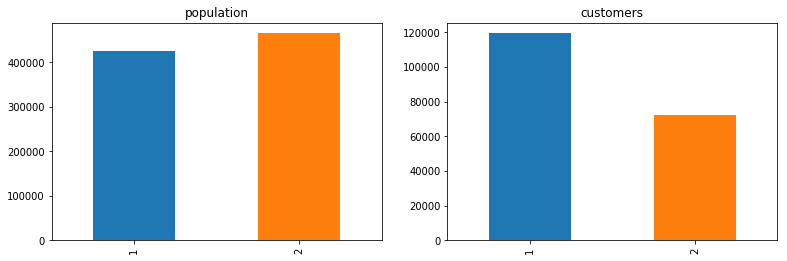

In [16]:
plot_feature_difference('ANREDE_KZ')


1	male

2	female


Now, we will compare the estimated household net income between the two groups

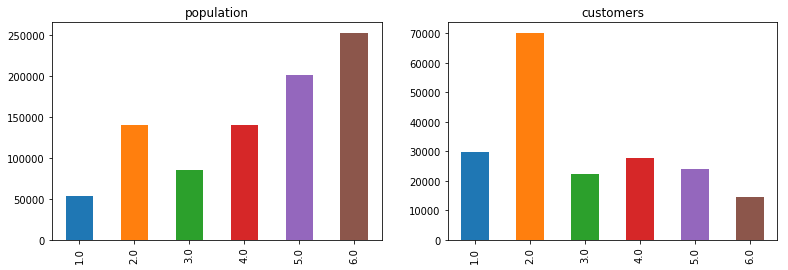

In [17]:
plot_feature_difference('HH_EINKOMMEN_SCORE')


1	highest income

2	very high income

3	high income

4	average income

5	lower income

6	very low income



Lastlt, we will compare the number of 1-2 family houses in the two populations

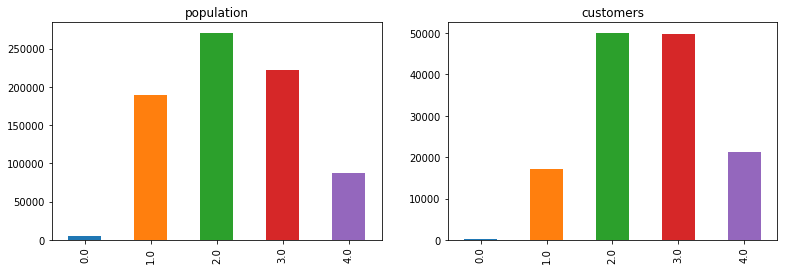

In [18]:
plot_feature_difference('PLZ8_ANTG1')

0	none

1	low share

2	average share

3	high share

4	very high share


Summary:

1. For the first feature, the main population has more feamles than males, while the customer population has more males than females

2. For the second feature, looking at the main population, the largest sector is those with a very low income while the lowest sector is those with the highest income. For the customer population on the other hand, the largest sector is those with very high income while the lowset sector is those with very low income

3. For the third feature, comparing the number of 1-2 family houses,the average share is the largest sector while low share is the lowset sector for both populations

### Data Preprocessing

Truth ne told, we can't work with all the fearutes in both datasets. For the two population data we have, we are going to reduce the number of features in both dataset to the maximum that we can handle. Reason being that we want to do away with features that will not be included in our analysis, and also to make our analysis straighforward

Filtering the azdias dataset

In [19]:
a = ['ALTERSKATEGORIE_GROB','ANREDE_KZ','CJT_GESAMTTYP','FINANZ_MINIMALIST','FINANZ_SPARER','FINANZ_VORSORGER','FINANZ_ANLEGER','FINANZ_UNAUFFAELLIGER','FINANZ_HAUSBAUER','FINANZTYP','GFK_URLAUBERTYP','GREEN_AVANTGARDE',
 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','LP_FAMILIE_FEIN','LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
 'SEMIO_FAM','SEMIO_REL','SEMIO_MAT','SEMIO_VERT','SEMIO_LUST','SEMIO_ERL','SEMIO_KULT','SEMIO_RAT','SEMIO_KRIT','SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT','SEMIO_TRADV','SHOPPER_TYP','SOHO_KZ',
 'VERS_TYP','ZABEOTYP','ANZ_PERSONEN','ANZ_TITEL','HH_EINKOMMEN_SCORE','KK_KUNDENTYP','W_KEIT_KIND_HH','WOHNDAUER_2008','ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','GEBAEUDETYP','KONSUMNAEHE','MIN_GEBAEUDEJAHR','OST_WEST_KZ','WOHNLAGE','CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015','KBA05_ANTG1',
 'KBA05_ANTG2','KBA05_ANTG3','KBA05_ANTG4','KBA05_GBZ','BALLRAUM','EWDICHTE','INNENSTADT','GEBAEUDETYP_RASTER','KKK','MOBI_REGIO','ONLINE_AFFINITAET','REGIOTYP','KBA13_ANZAHL_PKW','PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4','PLZ8_BAUMAX','PLZ8_HHZ','PLZ8_GBZ','ARBEIT','ORTSGR_KLS9','RELAT_AB']

In [20]:
azdias=azdias1[azdias1.columns[azdias1.columns.isin(a)]]


In [21]:
azdias.head()

ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  ARBEIT  \
0                  NaN           NaN           NaN        NaN     NaN   
1                 11.0           0.0           2.0        0.0     3.0   
2                 10.0           0.0           1.0        0.0     3.0   
3                  1.0           0.0           0.0        0.0     2.0   
4                  3.0           0.0           4.0        0.0     4.0   

   BALLRAUM CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  CJT_GESAMTTYP  \
0       NaN            NaN             NaN             NaN            2.0   
1       6.0             8A               8              51            5.0   
2       2.0             4C               4              24            3.0   
3       4.0             2A               2              12            2.0   
4       2.0             6B               6              43            5.0   

           ...           SEMIO_VERT  SHOPPER_TYP  SOHO_KZ  VERS_TYP  \
0          ...                    1           -1      NaN        -1   
1          ...                    1            3      1.0         2   
2          ...                    4            2      0.0         1   
3          ...                    4            1      0.0         1   
4          ...                    7            2      0.0         2   

   W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  ANREDE_KZ  \
0             NaN             NaN       NaN         3          1   
1             3.0             9.0       4.0         5          2   
2             3.0             9.0       2.0         5          2   
3             NaN             9.0       7.0         3          2   
4             2.0             9.0       3.0         4          1   

   ALTERSKATEGORIE_GROB  
0                     2  
1                     1  
2                     3  
3                     4  
4                     3  

[5 rows x 80 columns]

In [22]:
azdias.shape

(891221, 80)

In [23]:
customers=customers1[customers1.columns[customers1.columns.isin(a)]]

In [24]:
customers.head()

ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  ARBEIT  \
0                  1.0           0.0           2.0        0.0     1.0   
1                  NaN           NaN           3.0        0.0     NaN   
2                  1.0           0.0           1.0        0.0     3.0   
3                  0.0           NaN           0.0        0.0     1.0   
4                  7.0           0.0           4.0        0.0     3.0   

   BALLRAUM CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  CJT_GESAMTTYP  \
0       3.0             1A               1              13            5.0   
1       NaN            NaN             NaN             NaN            NaN   
2       7.0             5D               5              34            2.0   
3       7.0             4C               4              24            2.0   
4       3.0             7B               7              41            6.0   

           ...           SEMIO_VERT  SHOPPER_TYP  SOHO_KZ  VERS_TYP  \
0          ...                    6            3      0.0         1   
1          ...                    7            3      0.0         1   
2          ...                    3            1      0.0         2   
3          ...                    7            0      0.0         1   
4          ...                    5            1      0.0         2   

   W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  ANREDE_KZ  \
0             6.0             9.0       7.0         3          1   
1             0.0             9.0       NaN         3          1   
2             6.0             9.0       2.0         3          2   
3             NaN             9.0       7.0         1          1   
4             2.0             9.0       3.0         1          1   

   ALTERSKATEGORIE_GROB  
0                     4  
1                     4  
2                     4  
3                     4  
4                     3  

[5 rows x 80 columns]

In [25]:
customers.shape

(191652, 80)

Now, we have 85 features in both datasets to work with. Good!!!

### Dealing with missing values/nulls

Let us see the number of nulls we have in each dataset

In [26]:
azdias.isnull().sum().sum()

4616516

In [27]:
customers.isnull().sum().sum()

2103102

In [28]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 80 columns):
ANZ_HAUSHALTE_AKTIV      798073 non-null float64
ANZ_HH_TITEL             794213 non-null float64
ANZ_PERSONEN             817722 non-null float64
ANZ_TITEL                817722 non-null float64
ARBEIT                   794005 non-null float64
BALLRAUM                 797481 non-null float64
CAMEO_DEU_2015           792242 non-null object
CAMEO_DEUG_2015          792242 non-null object
CAMEO_INTL_2015          792242 non-null object
CJT_GESAMTTYP            886367 non-null float64
EWDICHTE                 797481 non-null float64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBAEUDETYP             

In [29]:
#  We will perform an assessment of how much missing data there is in each column of the
# dataset.
azdias1=azdias.isna().sum()
azdias1

ANZ_HAUSHALTE_AKTIV       93148
ANZ_HH_TITEL              97008
ANZ_PERSONEN              73499
ANZ_TITEL                 73499
ARBEIT                    97216
BALLRAUM                  93740
CAMEO_DEU_2015            98979
CAMEO_DEUG_2015           98979
CAMEO_INTL_2015           98979
CJT_GESAMTTYP              4854
EWDICHTE                  93740
FINANZ_ANLEGER                0
FINANZ_HAUSBAUER              0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_UNAUFFAELLIGER         0
FINANZ_VORSORGER              0
FINANZTYP                     0
GEBAEUDETYP               93148
GEBAEUDETYP_RASTER        93155
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
HH_EINKOMMEN_SCORE        18348
INNENSTADT                93740
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_ANTG4              133324
KBA05_GBZ                133324
KBA13_ANZAHL_PKW         105800
KK_KUNDE

Now, let us obtain the proportion of NaNs per column

In [30]:
len(azdias)

891221

In [31]:
azdias2= azdias.isna().sum()/891221*100
azdias2

ANZ_HAUSHALTE_AKTIV      10.451729
ANZ_HH_TITEL             10.884842
ANZ_PERSONEN              8.247000
ANZ_TITEL                 8.247000
ARBEIT                   10.908181
BALLRAUM                 10.518154
CAMEO_DEU_2015           11.106000
CAMEO_DEUG_2015          11.106000
CAMEO_INTL_2015          11.106000
CJT_GESAMTTYP             0.544646
EWDICHTE                 10.518154
FINANZ_ANLEGER            0.000000
FINANZ_HAUSBAUER          0.000000
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_VORSORGER          0.000000
FINANZTYP                 0.000000
GEBAEUDETYP              10.451729
GEBAEUDETYP_RASTER       10.452514
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP                0.000000
HH_EINKOMMEN_SCORE        2.058749
INNENSTADT               10.518154
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
KBA05_ANTG4         

We will now plot the proportion of NaNs in each column in azdias dataset on an histogram

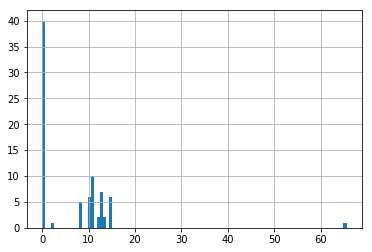

In [32]:
# Investigate patterns in the amount of missing data in each column.
azdias2.hist(bins=100)

In [33]:
# We will remove the outlier columns from the dataset.
#Setting 20 as the maximum proportion of missing values per column
azdais3 = azdias2[azdias2 > 20.0]
azdais4  = azdais3.index.tolist()
azdais4

['KK_KUNDENTYP']

Only one column above will be treated as an outlier; having a proportion of NaNs greater than 20

In [34]:
new_azdias = azdias.drop(azdais4, axis =1)
new_azdias

ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  ARBEIT  \
0                       NaN           NaN           NaN        NaN     NaN   
1                      11.0           0.0           2.0        0.0     3.0   
2                      10.0           0.0           1.0        0.0     3.0   
3                       1.0           0.0           0.0        0.0     2.0   
4                       3.0           0.0           4.0        0.0     4.0   
5                       5.0           0.0           1.0        0.0     2.0   
6                       4.0           0.0           1.0        0.0     4.0   
7                       6.0           0.0           1.0        0.0     2.0   
8                       2.0           1.0           1.0        0.0     2.0   
9                       9.0           0.0           1.0        0.0     2.0   
10                      6.0           0.0           1.0        0.0     4.0   
11                      NaN           NaN           NaN        NaN     NaN   
12                      1.0           0.0           2.0        0.0     3.0   
13                      2.0           0.0           1.0        0.0     3.0   
14                      NaN           NaN           NaN        NaN     NaN   
15                      1.0           0.0           1.0        0.0     4.0   
16                      0.0           0.0           0.0        0.0     1.0   
17                      NaN           NaN           NaN        NaN     NaN   
18                      2.0           0.0           1.0        0.0     3.0   
19                      1.0           0.0           2.0        0.0     4.0   
20                      1.0           0.0           1.0        0.0     3.0   
21                      2.0           0.0           1.0        0.0     5.0   
22                     14.0           0.0           1.0        0.0     4.0   
23                      1.0           0.0           2.0        0.0     3.0   
24                      NaN           NaN           NaN        NaN     NaN   
25                      1.0           0.0           0.0        0.0     3.0   
26                      1.0           0.0           1.0        0.0     4.0   
27                      6.0           0.0           2.0        0.0     4.0   
28                      3.0           0.0           1.0        0.0     3.0   
29                      1.0           0.0           1.0        0.0     2.0   
30                      NaN           NaN           1.0        0.0     NaN   
31                     11.0           0.0           1.0        0.0     4.0   
32                      1.0           0.0           2.0        0.0     4.0   
33                      3.0           0.0           4.0        0.0     3.0   
34                      1.0           0.0           1.0        0.0     4.0   
35                      NaN           NaN           NaN        NaN     NaN   
36                     13.0           0.0           1.0        0.0     4.0   
37                      1.0           0.0           3.0        0.0     3.0   
38                      2.0           0.0           1.0        0.0     3.0   
39                      1.0           0.0           3.0        0.0     3.0   
40                      3.0           0.0           1.0        0.0     3.0   
41                      1.0           0.0           5.0        0.0     3.0   
42                      2.0           0.0           1.0        0.0     3.0   
43                      4.0           0.0           1.0        0.0     3.0   
44                      4.0           0.0           1.0        0.0     1.0   
45                      1.0           0.0           5.0        0.0     3.0   
46                      NaN           NaN           1.0        0.0     NaN   
47                      2.0           0.0           1.0        0.0     3.0   
48                      NaN           NaN           NaN        NaN     NaN   
49                      1.0           0.0           1.0        0.0     3.0   
50                      6.0   

Let us see the number of missing values per row in our dataset

In [35]:
# How much data is missing in each row of the dataset?
azdias5=new_azdias.isnull().sum(axis = 1)
azdias5

0         38
1          0
2          0
3          1
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        38
12         6
13         8
14        38
15         8
16         1
17        38
18         0
19         0
20        10
21         0
22         0
23         8
24        38
25         1
26        19
27         0
28         0
29         0
30        33
31         0
32         0
33         0
34         0
35        38
36         0
37         0
38         0
39         5
40         3
41         0
42         0
43         0
44         0
45         0
46        33
47         0
48        38
49         0
50         0
51         0
52         0
53        38
54        38
55         0
56         0
57         0
58         0
59         0
60         0
61        38
62        38
63         0
64         1
65         0
66         0
67         0
68         0
69        38
70         7
71         0
72         0
73         8
74         0
75        38
76        38

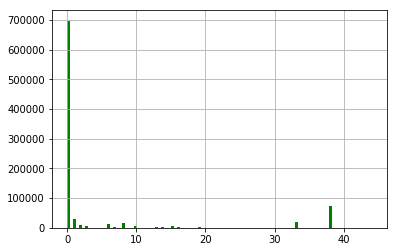

In [36]:
azdias5.hist(bins=100, color = 'green')

Let is set our threshold to be 20

In [37]:
# We will write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias6 = new_azdias[azdias5 <= 20]
azdias7 = new_azdias[azdias5 > 20]
azdias6

ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  ARBEIT  \
1                      11.0           0.0           2.0        0.0     3.0   
2                      10.0           0.0           1.0        0.0     3.0   
3                       1.0           0.0           0.0        0.0     2.0   
4                       3.0           0.0           4.0        0.0     4.0   
5                       5.0           0.0           1.0        0.0     2.0   
6                       4.0           0.0           1.0        0.0     4.0   
7                       6.0           0.0           1.0        0.0     2.0   
8                       2.0           1.0           1.0        0.0     2.0   
9                       9.0           0.0           1.0        0.0     2.0   
10                      6.0           0.0           1.0        0.0     4.0   
12                      1.0           0.0           2.0        0.0     3.0   
13                      2.0           0.0           1.0        0.0     3.0   
15                      1.0           0.0           1.0        0.0     4.0   
16                      0.0           0.0           0.0        0.0     1.0   
18                      2.0           0.0           1.0        0.0     3.0   
19                      1.0           0.0           2.0        0.0     4.0   
20                      1.0           0.0           1.0        0.0     3.0   
21                      2.0           0.0           1.0        0.0     5.0   
22                     14.0           0.0           1.0        0.0     4.0   
23                      1.0           0.0           2.0        0.0     3.0   
25                      1.0           0.0           0.0        0.0     3.0   
26                      1.0           0.0           1.0        0.0     4.0   
27                      6.0           0.0           2.0        0.0     4.0   
28                      3.0           0.0           1.0        0.0     3.0   
29                      1.0           0.0           1.0        0.0     2.0   
31                     11.0           0.0           1.0        0.0     4.0   
32                      1.0           0.0           2.0        0.0     4.0   
33                      3.0           0.0           4.0        0.0     3.0   
34                      1.0           0.0           1.0        0.0     4.0   
36                     13.0           0.0           1.0        0.0     4.0   
37                      1.0           0.0           3.0        0.0     3.0   
38                      2.0           0.0           1.0        0.0     3.0   
39                      1.0           0.0           3.0        0.0     3.0   
40                      3.0           0.0           1.0        0.0     3.0   
41                      1.0           0.0           5.0        0.0     3.0   
42                      2.0           0.0           1.0        0.0     3.0   
43                      4.0           0.0           1.0        0.0     3.0   
44                      4.0           0.0           1.0        0.0     1.0   
45                      1.0           0.0           5.0        0.0     3.0   
47                      2.0           0.0           1.0        0.0     3.0   
49                      1.0           0.0           1.0        0.0     3.0   
50                      6.0           0.0           1.0        0.0     2.0   
51                      2.0           0.0           3.0        0.0     3.0   
52                     10.0           0.0           1.0        0.0     4.0   
55                      9.0           0.0           1.0        0.0     3.0   
56                      2.0           0.0           4.0        0.0     3.0   
57                     10.0           0.0           2.0        0.0     4.0   
58                      2.0           0.0           2.0        0.0     3.0   
59                      8.0           0.0           1.0        0.0     4.0   
60                      8.0           1.0           1.0        0.0     3.0   
63                     11.0   

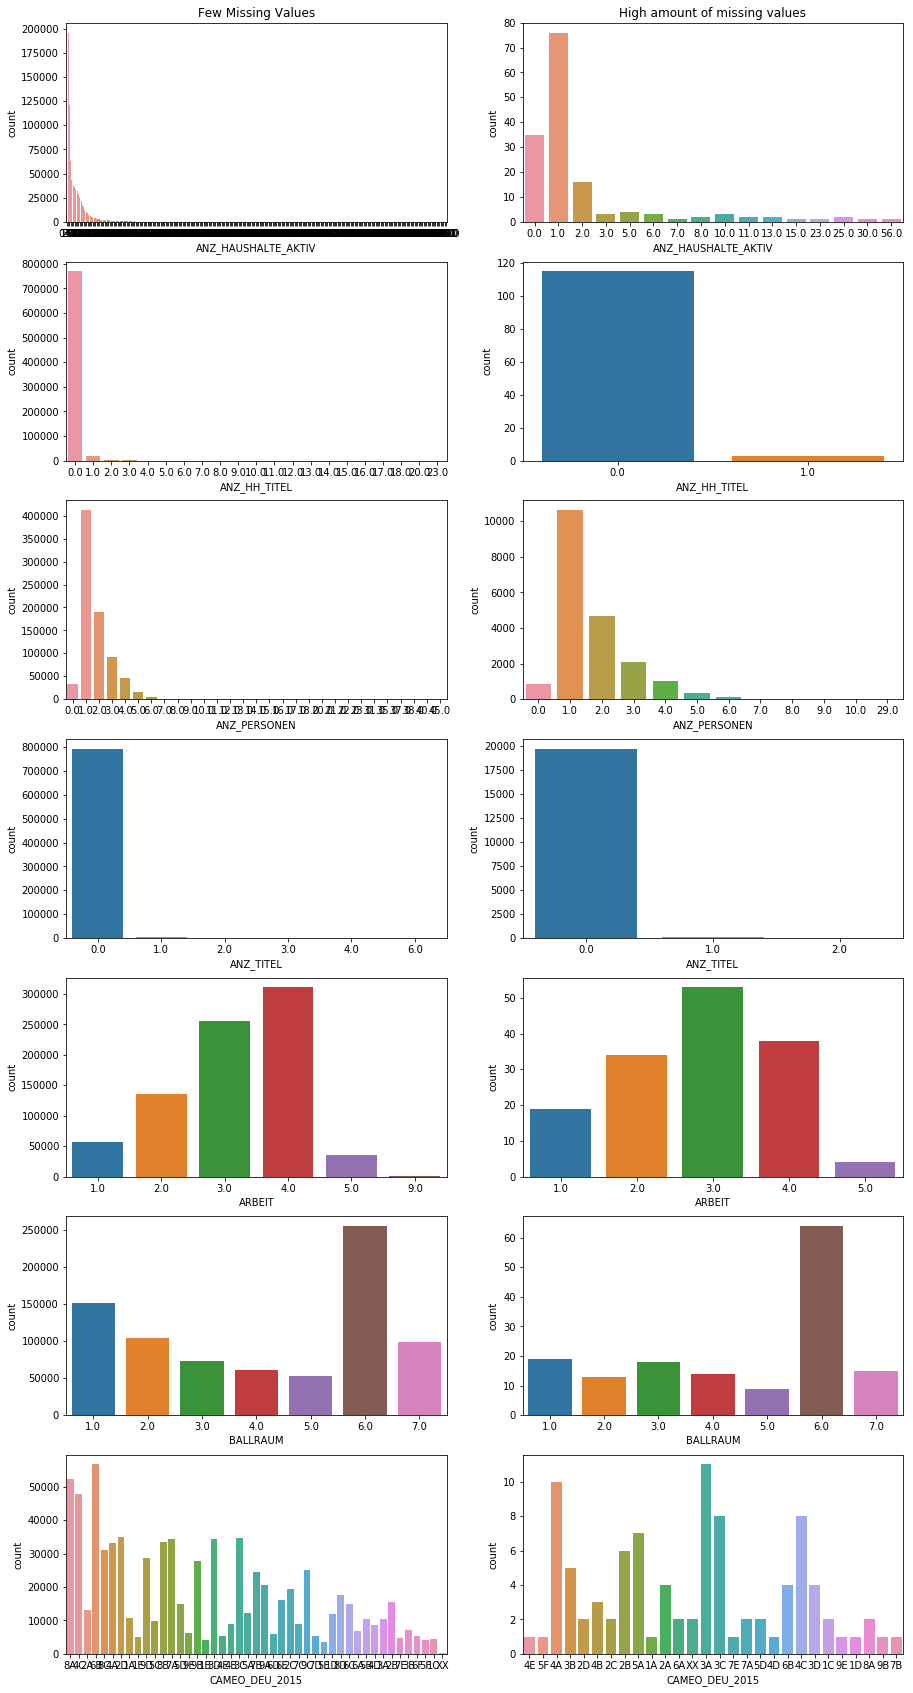

In [38]:
# Let is compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15,30), squeeze=False)
n=0
for columns in new_azdias.columns[:7]:
    sns.countplot(x=columns, data=azdias6, ax=axes[n,0])
    axes[0][0].set_title('Few Missing Values')
    sns.countplot(x=columns, data=azdias7, ax=axes[n,1])
    axes[0][1].set_title('High amount of missing values')
    n+=1

### Re-Encoding Features

In [39]:
azdias6.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 797920 entries, 1 to 891220
Data columns (total 79 columns):
ANZ_HAUSHALTE_AKTIV      797920 non-null float64
ANZ_HH_TITEL             794095 non-null float64
ANZ_PERSONEN             797920 non-null float64
ANZ_TITEL                797920 non-null float64
ARBEIT                   793857 non-null float64
BALLRAUM                 797329 non-null float64
CAMEO_DEU_2015           792147 non-null object
CAMEO_DEUG_2015          792147 non-null object
CAMEO_INTL_2015          792147 non-null object
CJT_GESAMTTYP            793278 non-null float64
EWDICHTE                 797329 non-null float64
FINANZ_ANLEGER           797920 non-null int64
FINANZ_HAUSBAUER         797920 non-null int64
FINANZ_MINIMALIST        797920 non-null int64
FINANZ_SPARER            797920 non-null int64
FINANZ_UNAUFFAELLIGER    797920 non-null int64
FINANZ_VORSORGER         797920 non-null int64
FINANZTYP                797920 non-null int64
GEBAEUDETYP             

From the result above, there are 4 columns that needs re-encoding, namely: CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015 and OST_WEST_KZ.  CAMEO_DEUG_2015 and CAMEO_INTL_2015 are multi-level categorical features, so we will drop them. However, we will re-encode CAMEO_DEU_2015 and OST_WEST_KZ

Re-encoding OST_WEST_KZ

In [40]:
azdias6['OST_WEST_KZ'].value_counts()

W    629401
O    168519
Name: OST_WEST_KZ, dtype: int64

Clearly, this attribute has non-numeric values. Therefore, we will replace the 'W' and 'O' with 0 and 1 respectively

In [41]:
new_values = {'W': 0, 'O': 1}
azdias6 = azdias6.replace({'OST_WEST_KZ':new_values})

In [42]:
azdias6['OST_WEST_KZ'].value_counts()

0    629401
1    168519
Name: OST_WEST_KZ, dtype: int64

Now, it is done. Great!!!

Re-encoding CAMEO_INTL_2015

We will need to convert the the 'CAMEO_INTL_2015' to numeric

In [43]:
azdias6['CAMEO_INTL_2015'] = pd.to_numeric(azdias6['CAMEO_INTL_2015'], errors = 'coercion')

In [44]:
Wealth= []
Life_Stage=[]
for values in azdias6["CAMEO_INTL_2015"]:
#Maping for Wealthy 
    if values in [11,12,13,14,15]:
        Wealth.append(5.0)
    elif values in [21,22,23,24,25]:
        Wealth.append(4.0)
    elif values in [31,32,33,34,35]:
        Wealth.append(3.0)
    elif values in [41,42,43,44,45]:
        Wealth.append(2.0)
    elif values in [51,52,53, 54, 55]:
        Wealth.append(1.0)
    else:
        Wealth.append(np.nan)
    #Maping Life Stage
        
    if values in [11,21,31,41,51]:
        Life_Stage.append(1.0)
    elif values in [12,22,32,42,52]:
        Life_Stage.append(2.0)
    elif values in [13,23,33,43,53]:
        Life_Stage.append(3.0)
    elif values in [14,24,34,44,54]:
        Life_Stage.append(4.0)
    elif values in [15,25,35,45,55]:
        Life_Stage.append(5.0)
    else:
        Life_Stage.append(np.nan)

    

Let us create another column called "CAMEO_INTL_2015_Life_Stage"

In [45]:
azdias6["CAMEO_INTL_2015_LIFE_STAGE"] = Life_Stage

We will create another column named "CAMEO_INTL_2015_Wealth"

In [46]:
azdias6["CAMEO_INTL_2015_WEALTH"] = Wealth

Now, we will drop the 'CAMEO_INTL_2015'

In [47]:
azdias6 = azdias6.drop('CAMEO_INTL_2015', axis =1)


In [48]:
azdias6 = azdias6.drop(['CAMEO_DEU_2015','CAMEO_DEUG_2015'], axis =1) 

In [49]:
azdias_new =azdias6 
azdias_new

ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  ARBEIT  \
1                      11.0           0.0           2.0        0.0     3.0   
2                      10.0           0.0           1.0        0.0     3.0   
3                       1.0           0.0           0.0        0.0     2.0   
4                       3.0           0.0           4.0        0.0     4.0   
5                       5.0           0.0           1.0        0.0     2.0   
6                       4.0           0.0           1.0        0.0     4.0   
7                       6.0           0.0           1.0        0.0     2.0   
8                       2.0           1.0           1.0        0.0     2.0   
9                       9.0           0.0           1.0        0.0     2.0   
10                      6.0           0.0           1.0        0.0     4.0   
12                      1.0           0.0           2.0        0.0     3.0   
13                      2.0           0.0           1.0        0.0     3.0   
15                      1.0           0.0           1.0        0.0     4.0   
16                      0.0           0.0           0.0        0.0     1.0   
18                      2.0           0.0           1.0        0.0     3.0   
19                      1.0           0.0           2.0        0.0     4.0   
20                      1.0           0.0           1.0        0.0     3.0   
21                      2.0           0.0           1.0        0.0     5.0   
22                     14.0           0.0           1.0        0.0     4.0   
23                      1.0           0.0           2.0        0.0     3.0   
25                      1.0           0.0           0.0        0.0     3.0   
26                      1.0           0.0           1.0        0.0     4.0   
27                      6.0           0.0           2.0        0.0     4.0   
28                      3.0           0.0           1.0        0.0     3.0   
29                      1.0           0.0           1.0        0.0     2.0   
31                     11.0           0.0           1.0        0.0     4.0   
32                      1.0           0.0           2.0        0.0     4.0   
33                      3.0           0.0           4.0        0.0     3.0   
34                      1.0           0.0           1.0        0.0     4.0   
36                     13.0           0.0           1.0        0.0     4.0   
37                      1.0           0.0           3.0        0.0     3.0   
38                      2.0           0.0           1.0        0.0     3.0   
39                      1.0           0.0           3.0        0.0     3.0   
40                      3.0           0.0           1.0        0.0     3.0   
41                      1.0           0.0           5.0        0.0     3.0   
42                      2.0           0.0           1.0        0.0     3.0   
43                      4.0           0.0           1.0        0.0     3.0   
44                      4.0           0.0           1.0        0.0     1.0   
45                      1.0           0.0           5.0        0.0     3.0   
47                      2.0           0.0           1.0        0.0     3.0   
49                      1.0           0.0           1.0        0.0     3.0   
50                      6.0           0.0           1.0        0.0     2.0   
51                      2.0           0.0           3.0        0.0     3.0   
52                     10.0           0.0           1.0        0.0     4.0   
55                      9.0           0.0           1.0        0.0     3.0   
56                      2.0           0.0           4.0        0.0     3.0   
57                     10.0           0.0           2.0        0.0     4.0   
58                      2.0           0.0           2.0        0.0     3.0   
59                      8.0           0.0           1.0        0.0     4.0   
60                      8.0           1.0           1.0        0.0     3.0   
63                     11.0   

In [50]:
azdias6["CAMEO_INTL_2015_WEALTH"].value_counts()

1.0    223578
4.0    190640
2.0    189952
5.0    119425
3.0     68181
Name: CAMEO_INTL_2015_WEALTH, dtype: int64

Now, let us create a cleaning function that performs all the cleaning steps we've taken above

In [51]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    #obtain the proportion of null in each column
    df1 = df.isna().sum()/891221*100
    
    # We will remove the outlier columns from the dataset. Setting 20 as the maximum proportion of missing values per column
    df1 = df1[df1 > 20.0]
    df1= df1.index.tolist()
    df2 = df.drop(df1, axis=1)
    
    # number of missing values in each row
    df3=df2.isnull().sum(axis=1)
    
     # We will write code to divide the data into two subsets based on the number of missing values in each row. We will select the sunset that has 20 or lower number of nulls
    df4 = df2[df3 <= 20]
    
    # re-coding feature
    new_values = {'W': 0, 'O': 1}
    df4 = df4.replace({'OST_WEST_KZ':new_values})
    df4['CAMEO_INTL_2015'] = pd.to_numeric(df4['CAMEO_INTL_2015'], errors = 'coercion')
    df4.drop('KK_KUNDENTYP', axis =1)
    
    Wealth= []
    Life_Stage=[]
    for values in df4["CAMEO_INTL_2015"]:
    #Maping for Wealthy 
        if values in [11,12,13,14,15]:
            Wealth.append(5.0)
        elif values in [21,22,23,24,25]:
            Wealth.append(4.0)
        elif values in [31,32,33,34,35]:
            Wealth.append(3.0)
        elif values in [41,42,43,44,45]:
            Wealth.append(2.0)
        elif values in [51,52,53, 54, 55]:
            Wealth.append(1.0)
        else:
            Wealth.append(np.nan)
        #Maping Life Stage
        
        if values in [11,21,31,41,51]:
            Life_Stage.append(1.0)
        elif values in [12,22,32,42,52]:
            Life_Stage.append(2.0)
        elif values in [13,23,33,43,53]:
            Life_Stage.append(3.0)
        elif values in [14,24,34,44,54]:
            Life_Stage.append(4.0)
        elif values in [15,25,35,45,55]:
            Life_Stage.append(5.0)
        else:
            Life_Stage.append(np.nan)
            
    df4["CAMEO_INTL_2015_LIFE_STAGE"] = Life_Stage
    df4["CAMEO_INTL_2015_WEALTH"] = Wealth
    df4 = df4.drop('CAMEO_INTL_2015', axis =1)
    df4 = df4.drop(['CAMEO_DEU_2015','CAMEO_DEUG_2015'], axis =1) 
    
    
    
    
    return df4

Let us apply the function on the customer data

In [52]:
customers_new = clean_data(customers)
customers_new

ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  ARBEIT  \
0                       1.0           0.0           2.0        0.0     1.0   
2                       1.0           0.0           1.0        0.0     3.0   
3                       0.0           NaN           0.0        0.0     1.0   
4                       7.0           0.0           4.0        0.0     3.0   
5                       1.0           0.0           2.0        0.0     3.0   
6                       1.0           0.0           2.0        0.0     2.0   
7                       1.0           0.0           2.0        0.0     3.0   
8                      74.0           2.0           1.0        0.0     3.0   
9                       1.0           0.0           3.0        0.0     3.0   
11                      1.0           0.0           1.0        0.0     2.0   
12                      1.0           0.0           3.0        0.0     1.0   
13                      1.0           0.0           2.0        0.0     4.0   
14                      9.0           0.0           1.0        0.0     3.0   
15                      1.0           0.0           5.0        0.0     3.0   
16                      1.0           0.0           2.0        0.0     3.0   
17                      1.0           0.0           6.0        0.0     1.0   
18                     17.0           0.0           1.0        0.0     3.0   
19                     12.0           0.0           1.0        0.0     3.0   
20                      1.0           0.0           3.0        0.0     4.0   
21                     29.0           0.0           1.0        0.0     1.0   
22                      2.0           0.0           3.0        0.0     1.0   
23                     45.0           0.0           1.0        0.0     3.0   
24                      2.0           0.0           4.0        0.0     2.0   
25                      1.0           0.0           4.0        0.0     1.0   
26                      2.0           0.0           2.0        0.0     1.0   
27                      1.0           0.0           5.0        0.0     3.0   
28                     10.0           0.0           1.0        0.0     3.0   
29                     14.0           0.0           1.0        0.0     3.0   
30                      2.0           0.0           2.0        0.0     2.0   
31                      1.0           0.0           4.0        0.0     2.0   
32                     15.0           0.0           1.0        0.0     4.0   
33                      1.0           0.0           1.0        0.0     3.0   
34                      1.0           0.0           4.0        0.0     1.0   
35                      1.0           0.0           2.0        0.0     3.0   
41                      2.0           0.0           2.0        0.0     3.0   
42                      1.0           0.0           2.0        0.0     2.0   
45                     55.0           4.0           1.0        0.0     3.0   
47                      2.0           0.0           3.0        0.0     2.0   
48                      1.0           0.0           2.0        0.0     4.0   
49                      1.0           0.0           2.0        0.0     1.0   
50                      1.0           0.0           1.0        0.0     2.0   
52                      1.0           0.0           1.0        0.0     3.0   
57                      2.0           2.0           2.0        1.0     3.0   
61                      1.0           0.0           1.0        0.0     2.0   
63                      1.0           0.0           2.0        0.0     2.0   
64                      1.0           0.0           4.0        0.0     4.0   
65                      1.0           0.0           1.0        0.0     3.0   
66                      1.0           1.0           3.0        1.0     3.0   
70                      0.0           NaN           0.0        0.0     4.0   
73                      1.0           0.0           1.0        0.0     1.0   
74                      1.0   

Great, our cleaning function works perfectly


In [53]:
customers_new.columns.difference(azdias6.columns)

Index(['KK_KUNDENTYP'], dtype='object')

In [54]:
customers_new.drop('KK_KUNDENTYP', axis =1, inplace=True)
customers_new

ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  ARBEIT  \
0                       1.0           0.0           2.0        0.0     1.0   
2                       1.0           0.0           1.0        0.0     3.0   
3                       0.0           NaN           0.0        0.0     1.0   
4                       7.0           0.0           4.0        0.0     3.0   
5                       1.0           0.0           2.0        0.0     3.0   
6                       1.0           0.0           2.0        0.0     2.0   
7                       1.0           0.0           2.0        0.0     3.0   
8                      74.0           2.0           1.0        0.0     3.0   
9                       1.0           0.0           3.0        0.0     3.0   
11                      1.0           0.0           1.0        0.0     2.0   
12                      1.0           0.0           3.0        0.0     1.0   
13                      1.0           0.0           2.0        0.0     4.0   
14                      9.0           0.0           1.0        0.0     3.0   
15                      1.0           0.0           5.0        0.0     3.0   
16                      1.0           0.0           2.0        0.0     3.0   
17                      1.0           0.0           6.0        0.0     1.0   
18                     17.0           0.0           1.0        0.0     3.0   
19                     12.0           0.0           1.0        0.0     3.0   
20                      1.0           0.0           3.0        0.0     4.0   
21                     29.0           0.0           1.0        0.0     1.0   
22                      2.0           0.0           3.0        0.0     1.0   
23                     45.0           0.0           1.0        0.0     3.0   
24                      2.0           0.0           4.0        0.0     2.0   
25                      1.0           0.0           4.0        0.0     1.0   
26                      2.0           0.0           2.0        0.0     1.0   
27                      1.0           0.0           5.0        0.0     3.0   
28                     10.0           0.0           1.0        0.0     3.0   
29                     14.0           0.0           1.0        0.0     3.0   
30                      2.0           0.0           2.0        0.0     2.0   
31                      1.0           0.0           4.0        0.0     2.0   
32                     15.0           0.0           1.0        0.0     4.0   
33                      1.0           0.0           1.0        0.0     3.0   
34                      1.0           0.0           4.0        0.0     1.0   
35                      1.0           0.0           2.0        0.0     3.0   
41                      2.0           0.0           2.0        0.0     3.0   
42                      1.0           0.0           2.0        0.0     2.0   
45                     55.0           4.0           1.0        0.0     3.0   
47                      2.0           0.0           3.0        0.0     2.0   
48                      1.0           0.0           2.0        0.0     4.0   
49                      1.0           0.0           2.0        0.0     1.0   
50                      1.0           0.0           1.0        0.0     2.0   
52                      1.0           0.0           1.0        0.0     3.0   
57                      2.0           2.0           2.0        1.0     3.0   
61                      1.0           0.0           1.0        0.0     2.0   
63                      1.0           0.0           2.0        0.0     2.0   
64                      1.0           0.0           4.0        0.0     4.0   
65                      1.0           0.0           1.0        0.0     3.0   
66                      1.0           1.0           3.0        1.0     3.0   
70                      0.0           NaN           0.0        0.0     4.0   
73                      1.0           0.0           1.0        0.0     1.0   
74                      1.0   

In [55]:
customers_new.columns.difference(azdias6.columns)

Index([], dtype='object')

For the purpose of this analysis, we are going to drop all the NaNs in this dataset

In [56]:
customers_new = customers_new.dropna(axis=0)
customers_new.head()

ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  ARBEIT  \
0                  1.0           0.0           2.0        0.0     1.0   
2                  1.0           0.0           1.0        0.0     3.0   
4                  7.0           0.0           4.0        0.0     3.0   
5                  1.0           0.0           2.0        0.0     3.0   
6                  1.0           0.0           2.0        0.0     2.0   

   BALLRAUM  CJT_GESAMTTYP  EWDICHTE  FINANZ_ANLEGER  FINANZ_HAUSBAUER  \
0       3.0            5.0       2.0               1                 2   
2       7.0            2.0       4.0               1                 4   
4       3.0            6.0       4.0               4                 2   
5       7.0            4.0       5.0               1                 3   
6       6.0            2.0       2.0               1                 2   

            ...            SOHO_KZ  VERS_TYP  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0           ...                0.0         1             6.0             9.0   
2           ...                0.0         2             6.0             9.0   
4           ...                0.0         2             2.0             9.0   
5           ...                0.0         2             6.0             9.0   
6           ...                0.0         1             6.0             9.0   

   WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB  \
0       7.0         3          1                     4   
2       2.0         3          2                     4   
4       3.0         1          1                     3   
5       1.0         2          1                     3   
6       7.0         1          1                     4   

   CAMEO_INTL_2015_LIFE_STAGE  CAMEO_INTL_2015_WEALTH  
0                         3.0                     5.0  
2                         4.0                     3.0  
4                         1.0                     2.0  
5                         4.0                     3.0  
6                         3.0                     4.0  

[5 rows x 78 columns]

We will fill all nulls with the mode

In [57]:
azdias_new =azdias_new.fillna(azdias_new.mode().iloc[0])
customers_new =customers_new.fillna(customers_new.mode().iloc[0])

Now, we will convert all columns to int datatype

In [58]:
azdias_new = azdias_new.astype(int)
customers_new = customers_new.astype(int)

 Feature Transformation

Now, we will apply feature scaling on the azdias dataset

In [59]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_azdias = scaler.fit_transform(azdias_new)

We will now convert the resulting array into a dataframe

In [60]:
scaled_azdias= pd.DataFrame(scaled_azdias, columns= azdias_new.columns)
scaled_azdias.head()

ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL    ARBEIT  \
0             0.173502     -0.125135      0.234395  -0.060382 -0.171888   
1             0.109519     -0.125135     -0.630256  -0.060382 -0.171888   
2            -0.466328     -0.125135     -1.494906  -0.060382 -1.170335   
3            -0.338362     -0.125135      1.963695  -0.060382  0.826559   
4            -0.210396     -0.125135     -0.630256  -0.060382 -1.170335   

   BALLRAUM  CJT_GESAMTTYP  EWDICHTE  FINANZ_ANLEGER  FINANZ_HAUSBAUER  \
0  0.845273       0.974314 -0.547226        1.465881          1.339193   
1 -0.986641      -0.329810  0.034420       -0.571032          1.339193   
2 -0.070684      -0.981871 -1.128873       -0.571032         -0.791484   
3 -0.986641       0.974314  0.616067       -1.250003         -0.791484   
4  0.845273      -0.981871 -1.128873       -0.571032          1.339193   

            ...              SOHO_KZ  VERS_TYP  W_KEIT_KIND_HH  \
0           ...            10.854792  0.832076       -0.578746   
1           ...            -0.092125 -0.559347       -0.578746   
2           ...            -0.092125 -0.559347        0.995627   
3           ...            -0.092125  0.832076       -1.103537   
4           ...            -0.092125  0.832076        0.995627   

   WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB  \
0        0.567198 -0.027201  1.151680   0.957884             -1.681230   
1        0.567198 -1.053230  1.151680   0.957884              0.169126   
2        0.567198  1.511841 -0.269017   0.957884              1.094305   
3        0.567198 -0.540216  0.441332  -1.043967              0.169126   
4        0.567198  1.511841  0.441332   0.957884             -1.681230   

   CAMEO_INTL_2015_LIFE_STAGE  CAMEO_INTL_2015_WEALTH  
0                   -1.248969               -1.175673  
1                    0.767017                0.869686  
2                   -0.576974                1.551473  
3                    0.095022               -0.493887  
4                    0.767017               -1.175673  

[5 rows x 78 columns]

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Implementation

Perform Dimensionality Reduction

We will create a do_pca function that help carry out the dimensionality reduction process

In [61]:
from sklearn.decomposition import PCA 
def do_pca(n_components, data):
    pca=PCA(n_components)
    x_pca= pca.fit_transform(data)
    return pca, x_pca


In [62]:
pca, X_pca = do_pca(33, scaled_azdias)
X_pca.shape

(797920, 33)

In [63]:
pca

PCA(copy=True, iterated_power='auto', n_components=33, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [64]:
# Investigate the variance accounted for by each principal component.
pca.explained_variance_ratio_.sum()

0.8628827977860668

In [65]:
for n_comp in range(25,60):
    pca, x_pca = do_pca(n_comp, scaled_azdias)
    if pca.explained_variance_ratio_.sum() >= 0.8:
        break

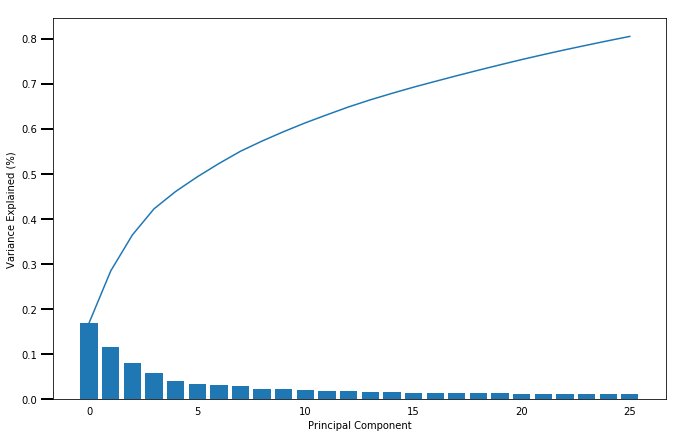

In [66]:
#Insight for the scree_plot function was gotten from the udacity classroom
def scree_plot(pca):
    
    
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(11, 7))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    
    ax.plot(ind, cumvals)
    
    
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    
scree_plot(pca)

In [67]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca= PCA(n_components=30)
df_pca = pca.fit_transform(scaled_azdias)


In [68]:
pca, X_pca = do_pca(30, scaled_azdias)

In [69]:
pca

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [70]:
X_pca.shape

(797920, 30)

In [71]:
pca.explained_variance_ratio_.sum()

0.84046650810506918

30 components explain 84% of variance in the dataset

Interpret Principal Components

Here, we will create a function to help calculate our pca dimensions

In [72]:
#Insight for this function was drawn from Knowledge
def pca_dims(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    '''
    
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [73]:
pca_dims(scaled_azdias, pca)

Explained Variance  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
Dimension 1               0.1688               0.1259        0.0318   
Dimension 2               0.1152               0.0401        0.0246   
Dimension 3               0.0798               0.0239        0.0119   
Dimension 4               0.0579               0.0326        0.0230   
Dimension 5               0.0385               0.0678       -0.0183   
Dimension 6               0.0325               0.0192        0.0217   
Dimension 7               0.0295              -0.0832       -0.0466   
Dimension 8               0.0274               0.3001        0.2183   
Dimension 9               0.0227               0.1582        0.0443   
Dimension 10              0.0209               0.2268        0.1942   
Dimension 11              0.0195              -0.0187       -0.0515   
Dimension 12              0.0179               0.0422       -0.0052   
Dimension 13              0.0175              -0.0215        0.0340   
Dimension 14              0.0156               0.1390        0.6079   
Dimension 15              0.0144               0.0663        0.1363   
Dimension 16              0.0137              -0.1348        0.0529   
Dimension 17              0.0128               0.0088       -0.0021   
Dimension 18              0.0127              -0.0428        0.0105   
Dimension 19              0.0122              -0.0474       -0.0305   
Dimension 20              0.0119              -0.1564       -0.1235   
Dimension 21              0.0117               0.0735        0.1079   
Dimension 22              0.0110              -0.0216        0.0197   
Dimension 23              0.0107              -0.1980       -0.2716   
Dimension 24              0.0102               0.0315       -0.0016   
Dimension 25              0.0100              -0.2091       -0.3190   
Dimension 26              0.0096              -0.0502       -0.0004   
Dimension 27              0.0095               0.0326        0.2240   
Dimension 28              0.0091               0.0198       -0.0444   
Dimension 29              0.0088              -0.0210        0.1114   
Dimension 30              0.0083              -0.0660        0.2026   

              ANZ_PERSONEN  ANZ_TITEL  ARBEIT  BALLRAUM  CJT_GESAMTTYP  \
Dimension 1        -0.1045    -0.0041  0.1267   -0.1135         0.0312   
Dimension 2        -0.0692     0.0066  0.0428   -0.0368        -0.1293   
Dimension 3        -0.0166     0.0084  0.0359   -0.0323        -0.0379   
Dimension 4         0.3164     0.0234  0.1019   -0.1386         0.0569   
Dimension 5         0.1486    -0.0314 -0.0287    0.2132        -0.0283   
Dimension 6         0.0817     0.0222 -0.1043   -0.0272         0.0525   
Dimension 7        -0.0470    -0.0022  0.2005   -0.0462         0.0503   
Dimension 8        -0.0244     0.0647 -0.1420   -0.0111         0.0031   
Dimension 9        -0.0348    -0.0228 -0.0546   -0.1192         0.0567   
Dimension 10        0.0499     0.0709 -0.0150   -0.0956        -0.0834   
Dimension 11       -0.0205    -0.0208  0.0974    0.0593        -0.0504   
Dimension 12       -0.0130    -0.0209  0.4325    0.0544         0.0732   
Dimension 13       -0.0200     0.0488 -0.1312    0.1044         0.0219   
Dimension 14       -0.0045     0.6130  0.1286    0.1609        -0.0410   
Dimension 15       -0.0093     0.1038 -0.0538   -0.1778         0.3808   
Dimension 16        0.0031     0.2226 -0.2202   -0.2578        -0.0069   
Dimension 17       -0.0004    -0.0129 -0.0058    0.0224         0.0443   
Dimension 18       -0.0199     0.1197 -0.0559   -0.0459         0.0373   
Dimension 19        0.0033     0.1632 -0.1127    0.1270         0.1696   
Dimension 20        0.0229     0.2938  0.0810   -0.1324        -0.4783   
Dimension 21        0.0116    -0.1264  0.0057   -0.1874        -0.1467   
Dimension 22        0.0097    -0.0170  0.0474    0.0560        -0.1316   
Dimension 23        0.0082     0.4531  0.0543   -0.0782         0.2720   
Dimension 24       -0.0014     0.088

In [74]:
#Insight for this function was drawn from Knowledge
def pca_results(full_dataset, pca):

    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    #PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (15,10))
    
    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)
    
    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.03, "Explained Variance\n          %.4f"%(ev))
    
    # Return a concatenated DataFrame
    #return pd.concat([variance_ratios, components], axis = 1)

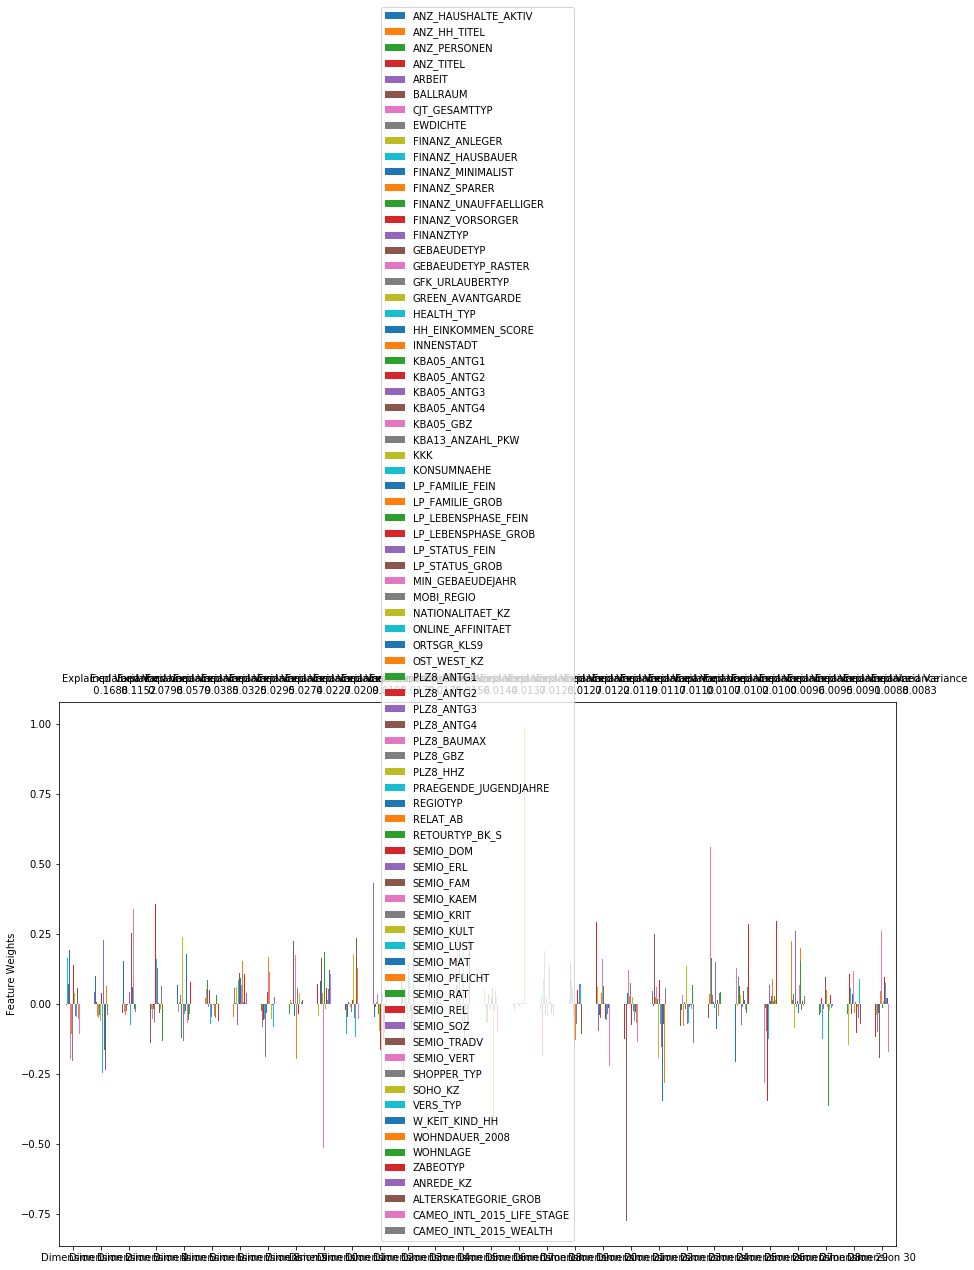

In [75]:
pca_results(scaled_azdias, pca)

In [76]:
data=pd.DataFrame(pca.components_, columns = scaled_azdias.columns)
weights= data.sort_values
display(weights)

<bound method DataFrame.sort_values of     ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL    ARBEIT  \
0              0.125866      0.031783     -0.104464  -0.004132  0.126743   
1              0.040120      0.024563     -0.069240   0.006556  0.042756   
2              0.023897      0.011943     -0.016629   0.008360  0.035928   
3              0.032569      0.022982      0.316433   0.023426  0.101852   
4              0.067775     -0.018343      0.148566  -0.031368 -0.028718   
5              0.019153      0.021742      0.081704   0.022244 -0.104265   
6             -0.083243     -0.046602     -0.047019  -0.002225  0.200543   
7              0.300068      0.218264     -0.024385   0.064677 -0.142022   
8              0.158243      0.044342     -0.034832  -0.022756 -0.054609   
9              0.226750      0.194190      0.049865   0.070947 -0.015035   
10            -0.018662     -0.051538     -0.020495  -0.020802  0.097353   
11             0.042183     -0.005162     -0.0130

In [77]:
# Map weights for the first principal component to corresponding feature names and then print the linked values, sorted by weight.
def pca_weights(item, pca):
    df = pd.DataFrame(pca.components_, columns=scaled_azdias.columns)
    weights = df.iloc[item].sort_values(ascending=False)
    return weights

In [78]:
pca_weights(0,pca)

PLZ8_ANTG3                    0.203879
PLZ8_ANTG4                    0.197068
PLZ8_BAUMAX                   0.193359
HH_EINKOMMEN_SCORE            0.192828
ORTSGR_KLS9                   0.178518
EWDICHTE                      0.176368
FINANZ_HAUSBAUER              0.163424
KBA05_ANTG4                   0.141163
PLZ8_ANTG2                    0.139875
ZABEOTYP                      0.130003
KBA05_ANTG3                   0.127434
ARBEIT                        0.126743
ANZ_HAUSHALTE_AKTIV           0.125866
RELAT_AB                      0.120396
FINANZ_SPARER                 0.108376
SEMIO_PFLICHT                 0.079140
SEMIO_REL                     0.074859
GEBAEUDETYP                   0.069971
REGIOTYP                      0.068475
SEMIO_RAT                     0.066275
GFK_URLAUBERTYP               0.058806
SEMIO_TRADV                   0.055141
SEMIO_MAT                     0.054530
W_KEIT_KIND_HH                0.053954
SEMIO_FAM                     0.050903
KKK                      

In [79]:
pca_weights(1,pca)

ALTERSKATEGORIE_GROB          0.253892
FINANZ_VORSORGER              0.240717
SEMIO_ERL                     0.229616
SEMIO_LUST                    0.186001
RETOURTYP_BK_S                0.164378
W_KEIT_KIND_HH                0.123325
FINANZTYP                     0.115291
SEMIO_KRIT                    0.108714
FINANZ_MINIMALIST             0.098292
SEMIO_KAEM                    0.095553
SHOPPER_TYP                   0.093295
FINANZ_HAUSBAUER              0.087507
ANREDE_KZ                     0.078530
WOHNDAUER_2008                0.062275
SEMIO_DOM                     0.059966
EWDICHTE                      0.056737
ORTSGR_KLS9                   0.055469
PLZ8_ANTG3                    0.053538
PLZ8_ANTG4                    0.053120
PLZ8_BAUMAX                   0.049155
KBA05_ANTG4                   0.045325
ARBEIT                        0.042756
RELAT_AB                      0.040630
ANZ_HAUSHALTE_AKTIV           0.040120
PLZ8_ANTG2                    0.037221
HH_EINKOMMEN_SCORE       

In [80]:
pca_weights(2,pca)

SEMIO_VERT                    0.339363
SEMIO_SOZ                     0.260331
SEMIO_FAM                     0.252531
SEMIO_KULT                    0.240226
FINANZ_MINIMALIST             0.154224
FINANZTYP                     0.119284
RETOURTYP_BK_S                0.103516
W_KEIT_KIND_HH                0.093420
FINANZ_VORSORGER              0.090234
SEMIO_REL                     0.078035
ALTERSKATEGORIE_GROB          0.062569
SEMIO_MAT                     0.059802
SEMIO_LUST                    0.053216
PLZ8_BAUMAX                   0.049787
PLZ8_ANTG4                    0.046290
ORTSGR_KLS9                   0.044564
PLZ8_ANTG3                    0.043979
EWDICHTE                      0.042796
VERS_TYP                      0.039106
GREEN_AVANTGARDE              0.038384
LP_STATUS_GROB                0.037317
ARBEIT                        0.035928
RELAT_AB                      0.030327
WOHNDAUER_2008                0.028579
PLZ8_ANTG2                    0.027821
KBA05_ANTG4              

Summary:

### For the first component:

The first principal component has a strong correlation with PLZ8_ANTG3 and PLZ8_ANTG4, which are the number of 6-10 family houses in the PLZ8 region and number of 10+ family houses in the PLZ8 region repectively. This implies that the two features varies together. An increase in the number of number of 6-10 family houses will result in a corrsponding increase in the number of 10+ family houses in the PLZ8 region. Therfore have an increase in the number of 6-10 family houses and 10+ family houses in the PLZ8 region is what we want.

Also the first component has a strong negative correlation with LP_STATUS_GROB and LP_STATUS_FEIN, which are the Movement patterns and Low financial interest typology respectively. This implies that the two features varies together. An increase in the Movement patterns will result in a corrsponding increase in the Low financial interest typology. Therfore have an decrease in the Movement patterns and Low financial interest typology is what we want.




### For the second component:

The second principal component has a strong correlation with ALTERSKATEGORIE_GROB and FINANZ_VORSORGER, which are the Estimated age based on given name analysis and Financial typology(VORSORGER) repectively. This implies that the two features varies together. An increase in the Estimated age  will result in a corrsponding increase in the Financial typology(VORSORGER). Therfore have an increase in the Estimated age and Financial typology(VORSORGER) is what we want.

Also the second component has a strong negative correlation with FINANZ_SPARER and SEMIO_REL, which are the Personality typology(religious) and the Dominating movement of person's youth respectively. This implies that the two features varies together. An increase in the Personality typology(religious) will result in a corrsponding increase in the Dominating movement of person's youth. Therfore have an decrease in the Personality typology(religious) and Dominating movement of person's youth is what we want.
            

### For the third component:

The third principal component has a strong correlation with SEMIO_VERT and SEMIO_SOZ, which are the Personality typology(VERT: dreamful) and Personality typology(socially-minded) repectively. This implies that the two features varies together. An increase in the Personality typology(VERT: dreamful) will result in a corrsponding increase in the Personality typology(socially-minded)). Therfore have an increase in the Personality typology(VERT: dreamful) and Personality typology(socially-minded) is what we want.

Also the third component has a strong negative correlation with ANREDE_KZ and SEMIO_KAEM, which are the Gender and the Personal typology(combative attitude) respectively. This implies that the two features varies together. An increase in the Gender will result in a corrsponding increase in the Personal typology(combative attitude). Therfore have an decrease in the Gender and Personal typology(combative attitude)is what we want.


Apply Clustering to General Population

In [81]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

def kmeans_score(data, clusters):
        
    kmeans=KMeans(n_clusters=clusters)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    
    return score

    # run k-means clustering on the data and...
    

In [82]:
score = []

clusters = list(range(2,8))

for cluster in clusters:
    score.append(kmeans_score(X_pca, cluster))

In [83]:
score

[44400336.587115481,
 40918105.112919196,
 38741580.386490263,
 37294780.064058572,
 35946239.923405163,
 34739821.567578845]

### Refinement

Text(0.5,1,'Elbow Curve')

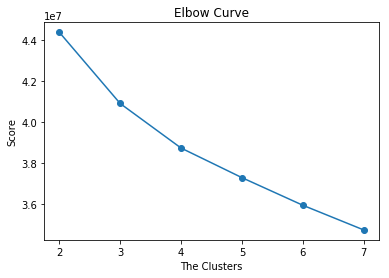

In [84]:
# Investigating the change in within-cluster distance across number of clusters.
# Using matplotlib's plot function to visualize this relationship.
plt.plot(clusters, score, linestyle='-', marker='o')
plt.xlabel('The Clusters')
plt.ylabel('Score')
plt.title("Elbow Curve")


In [85]:
# Re-fiting the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans= KMeans(4)

In [86]:
model = kmeans.fit(X_pca)

In [87]:
model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [88]:
scaled_azdias_pred = model.predict(X_pca)
scaled_azdias_pred

array([3, 2, 1, ..., 2, 3, 0], dtype=int32)

Apply All Steps to the Customer Data

In [89]:
customers_new.head()

ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  ARBEIT  \
0                    1             0             2          0       1   
2                    1             0             1          0       3   
4                    7             0             4          0       3   
5                    1             0             2          0       3   
6                    1             0             2          0       2   

   BALLRAUM  CJT_GESAMTTYP  EWDICHTE  FINANZ_ANLEGER  FINANZ_HAUSBAUER  \
0         3              5         2               1                 2   
2         7              2         4               1                 4   
4         3              6         4               4                 2   
5         7              4         5               1                 3   
6         6              2         2               1                 2   

            ...            SOHO_KZ  VERS_TYP  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0           ...                  0         1               6               9   
2           ...                  0         2               6               9   
4           ...                  0         2               2               9   
5           ...                  0         2               6               9   
6           ...                  0         1               6               9   

   WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB  \
0         7         3          1                     4   
2         2         3          2                     4   
4         3         1          1                     3   
5         1         2          1                     3   
6         7         1          1                     4   

   CAMEO_INTL_2015_LIFE_STAGE  CAMEO_INTL_2015_WEALTH  
0                           3                       5  
2                           4                       3  
4                           1                       2  
5                           4                       3  
6                           3                       4  

[5 rows x 78 columns]

Let's start by scalling the datast

In [90]:
scaled_customers= scaler.transform(customers_new)
scaled_customers=pd.DataFrame(scaled_customers, columns=customers_new.columns )


In [91]:
scaled_customers.head()

ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL    ARBEIT  \
0            -0.466328     -0.125135      0.234395  -0.060382 -2.168782   
1            -0.466328     -0.125135     -0.630256  -0.060382 -0.171888   
2            -0.082430     -0.125135      1.963695  -0.060382 -0.171888   
3            -0.466328     -0.125135      0.234395  -0.060382 -0.171888   
4            -0.466328     -0.125135      0.234395  -0.060382 -1.170335   

   BALLRAUM  CJT_GESAMTTYP  EWDICHTE  FINANZ_ANLEGER  FINANZ_HAUSBAUER  \
0 -0.528662       0.974314 -1.128873       -1.250003         -0.791484   
1  1.303252      -0.981871  0.034420       -1.250003          0.628967   
2 -0.528662       1.626375  0.034420        0.786910         -0.791484   
3  1.303252       0.322252  0.616067       -1.250003         -0.081259   
4  0.845273      -0.981871 -1.128873       -1.250003         -0.791484   

            ...             SOHO_KZ  VERS_TYP  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0           ...           -0.092125 -0.559347        0.995627        0.567198   
1           ...           -0.092125  0.832076        0.995627        0.567198   
2           ...           -0.092125  0.832076       -1.103537        0.567198   
3           ...           -0.092125  0.832076        0.995627        0.567198   
4           ...           -0.092125 -0.559347        0.995627        0.567198   

   WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB  \
0  1.511841 -0.269017  -1.043967              1.094305   
1 -1.053230 -0.269017   0.957884              1.094305   
2 -0.540216 -1.689713  -1.043967              0.169126   
3 -1.566244 -0.979365  -1.043967              0.169126   
4  1.511841 -1.689713  -1.043967              1.094305   

   CAMEO_INTL_2015_LIFE_STAGE  CAMEO_INTL_2015_WEALTH  
0                    0.095022                1.551473  
1                    0.767017                0.187900  
2                   -1.248969               -0.493887  
3                    0.767017                0.187900  
4                    0.095022                0.869686  

[5 rows x 78 columns]

We will project the clustering from the general demographics onto the customer data, obtaining cluster predictions for the customer demographics data.

In [92]:
customers_pca = pca.transform(scaled_customers)
pred_customers = model.predict(customers_pca)


In [93]:
pred_customers

array([1, 0, 2, ..., 1, 1, 1], dtype=int32)

Now we will compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the  generalpopulation.

In [94]:
#Insight drawn from Knwoledge
def compare(x,y):
    sns.set_style("whitegrid")
    fig, (bx1, bx2) = plt.subplots(1, 2, figsize = (15,5), )
    
    bx1.set_title('General', fontweight = 'bold')
    sns.countplot(x,ax = bx1, color='r')

    bx2.set_title('Customers', fontweight = 'bold')
    sns.countplot(y, ax = bx2, color='g')
    plt.show()

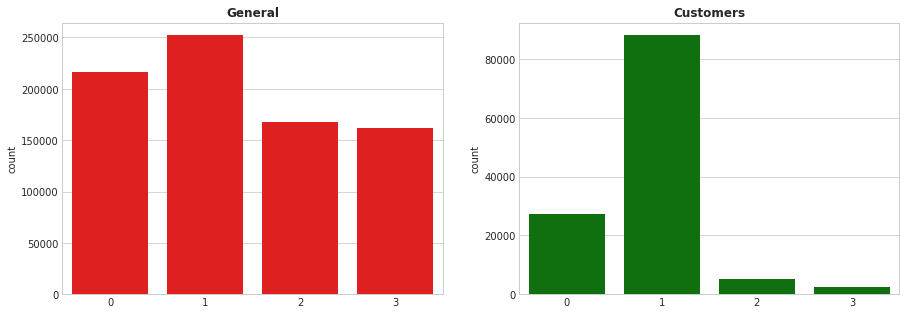

In [95]:
compare(scaled_azdias_pred, pred_customers)

In [96]:
pred_cust = pd.Series(pred_customers).value_counts().sort_index()
data_prediction = pd.Series(scaled_azdias_pred).value_counts().sort_index()
df_new = pd.concat([data_prediction, pred_cust], axis=1).reset_index()
df_new.columns = ['Cluster','General_Prediction', 'Customer_Prediction']
df_new

Cluster  General_Prediction  Customer_Prediction
0        0              216171                27280
1        1              251975                88034
2        2              167497                 5330
3        3              162277                 2561

Now, let us obtain our centriods

In [97]:
centroid_1= scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[1]))

In [98]:
data1 = pd.Series(data = centroid_1, index = customers_new.columns)
data1

ANZ_HAUSHALTE_AKTIV              1.749123
ANZ_HH_TITEL                     0.011124
ANZ_PERSONEN                     2.039189
ANZ_TITEL                        0.005558
ARBEIT                           2.787813
BALLRAUM                         4.835989
CJT_GESAMTTYP                    3.063492
EWDICHTE                         3.018088
FINANZ_ANLEGER                   2.152807
FINANZ_HAUSBAUER                 2.269847
FINANZ_MINIMALIST                4.398044
FINANZ_SPARER                    1.621641
FINANZ_UNAUFFAELLIGER            1.988442
FINANZ_VORSORGER                 4.242936
FINANZTYP                        4.584366
GEBAEUDETYP                      2.114214
GEBAEUDETYP_RASTER               4.049738
GFK_URLAUBERTYP                  6.587519
GREEN_AVANTGARDE                 0.418084
HEALTH_TYP                       2.070966
HH_EINKOMMEN_SCORE               3.230133
INNENSTADT                       5.421247
KBA05_ANTG1                      2.506688
KBA05_ANTG2                      1

In [99]:
centroid_0= scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[0]))

In [100]:
data = pd.Series(data = centroid_0, index = customers_new.columns)
data

ANZ_HAUSHALTE_AKTIV             14.678807
ANZ_HH_TITEL                     0.083628
ANZ_PERSONEN                     1.354573
ANZ_TITEL                        0.004990
ARBEIT                           3.569248
BALLRAUM                         3.507873
CJT_GESAMTTYP                    3.103247
EWDICHTE                         4.861035
FINANZ_ANLEGER                   1.954712
FINANZ_HAUSBAUER                 4.007844
FINANZ_MINIMALIST                2.878701
FINANZ_SPARER                    1.895390
FINANZ_UNAUFFAELLIGER            1.682168
FINANZ_VORSORGER                 4.279864
FINANZTYP                        4.597562
GEBAEUDETYP                      3.329472
GEBAEUDETYP_RASTER               3.463775
GFK_URLAUBERTYP                  7.503871
GREEN_AVANTGARDE                 0.070128
HEALTH_TYP                       2.122717
HH_EINKOMMEN_SCORE               5.377648
INNENSTADT                       3.722368
KBA05_ANTG1                      0.459345
KBA05_ANTG2                      1

In [101]:
centroid_2= scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[2]))
data2 = pd.Series(data = centroid_2, index = customers_new.columns)
data2

ANZ_HAUSHALTE_AKTIV              3.191567
ANZ_HH_TITEL                     0.008820
ANZ_PERSONEN                     2.067805
ANZ_TITEL                        0.003078
ARBEIT                           2.772529
BALLRAUM                         4.947928
CJT_GESAMTTYP                    4.158488
EWDICHTE                         2.997281
FINANZ_ANLEGER                   4.048722
FINANZ_HAUSBAUER                 2.449799
FINANZ_MINIMALIST                2.769895
FINANZ_SPARER                    3.893733
FINANZ_UNAUFFAELLIGER            3.848006
FINANZ_VORSORGER                 2.314994
FINANZTYP                        2.857730
GEBAEUDETYP                      2.460880
GEBAEUDETYP_RASTER               3.985701
GFK_URLAUBERTYP                  7.632604
GREEN_AVANTGARDE                 0.242750
HEALTH_TYP                       2.099728
HH_EINKOMMEN_SCORE               3.859077
INNENSTADT                       5.449330
KBA05_ANTG1                      2.007514
KBA05_ANTG2                      1

In [102]:
centroid_3= scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[3]))
data3 = pd.Series(data = centroid_3, index = customers_new.columns)
data3

ANZ_HAUSHALTE_AKTIV             15.186739
ANZ_HH_TITEL                     0.061122
ANZ_PERSONEN                     1.396200
ANZ_TITEL                        0.001993
ARBEIT                           3.652189
BALLRAUM                         3.138534
CJT_GESAMTTYP                    4.055309
EWDICHTE                         5.121028
FINANZ_ANLEGER                   3.844070
FINANZ_HAUSBAUER                 3.921283
FINANZ_MINIMALIST                1.517268
FINANZ_SPARER                    4.293438
FINANZ_UNAUFFAELLIGER            3.770594
FINANZ_VORSORGER                 2.200481
FINANZTYP                        2.481670
GEBAEUDETYP                      3.503678
GEBAEUDETYP_RASTER               3.364910
GFK_URLAUBERTYP                  8.763433
GREEN_AVANTGARDE                 0.086446
HEALTH_TYP                       1.878478
HH_EINKOMMEN_SCORE               5.539848
INNENSTADT                       3.370498
KBA05_ANTG1                      0.402940
KBA05_ANTG2                      1

Summary:


As seen from our analysis, cluster 1 is overrepresented in the customer data compared to that of the general population data. 
Some characteristics of the group of population that are relative popular with the mail-order company:

1. PRAEGENDE_JUGENDJAHRE_DECADE (51.592653) representing the Dominating movement of person's youth: meaning the mail order is more prominent of folks in the 70's 
2. ANZ_HH_TITEL (0.061972) representing the Number of cars in the PLZ8 region: meaning the mail order is more prominent of folks with very high share of 1-2 family homes
3. ANZ_PERSONEN (1.393201) representing the First year building was mentioned in the database: meaning the mail order is more prominent of folks with building location i the West

Also, cluster 0 is underrepresented in the customer data compared to that of the general population data. Some characteristics of the segment of the population that are relatively unpopular with the company:

1. ALTERSKATEGORIE_GROB (1.880218) representing the Dominating movement of person's youth: meaning the mail order is more prominent of folks in the 90's 
2. CAMEO_INTL_2015_LIFE_STAGE (2.042701) representing the Number of cars in the PLZ8 region: meaning the mail order is more prominent of folks lower share of 1-2 family homes
3. CAMEO_INTL_2015_WEALTH   (1.659711) representing the First year building was mentioned in the database:  meaning the mail order is more prominent of folks with building location i the West

The same thing goes for other centriods but with differnt values

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [103]:
df_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [104]:
df_train.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  1763         2         1.0       8.0          NaN          NaN   
1  1771         1         4.0      13.0          NaN          NaN   
2  1776         1         1.0       9.0          NaN          NaN   
3  1460         2         1.0       6.0          NaN          NaN   
4  1783         2         1.0       9.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   8.0                 15.0   
1          NaN          NaN                  13.0                  1.0   
2          NaN          NaN                   7.0                  0.0   
3          NaN          NaN                   6.0                  4.0   
4          NaN          NaN                   9.0                 53.0   

          ...           VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
0         ...                5.0         2.0      1.0             6.0   
1         ...                1.0         2.0      1.0             4.0   
2         ...                6.0         4.0      2.0             NaN   
3         ...                8.0        11.0     11.0             6.0   
4         ...                2.0         2.0      1.0             6.0   

   WOHNDAUER_2008  WOHNLAGE  ZABEOTYP RESPONSE ANREDE_KZ ALTERSKATEGORIE_GROB  
0             9.0       3.0         3        0         2                    4  
1             9.0       7.0         1        0         2                    3  
2             9.0       2.0         3        0         1                    4  
3             9.0       1.0         3        0         2                    4  
4             9.0       3.0         3        0         1                    3  

[5 rows x 367 columns]

In [105]:
df_train.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [106]:
df_train.shape

(42962, 367)

In [107]:
a = ['ALTERSKATEGORIE_GROB','ANREDE_KZ','CJT_GESAMTTYP','FINANZ_MINIMALIST','FINANZ_SPARER','FINANZ_VORSORGER','FINANZ_ANLEGER','FINANZ_UNAUFFAELLIGER','FINANZ_HAUSBAUER','FINANZTYP','GFK_URLAUBERTYP','GREEN_AVANTGARDE',
 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','LP_FAMILIE_FEIN','LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
 'SEMIO_FAM','SEMIO_REL','SEMIO_MAT','SEMIO_VERT','SEMIO_LUST','SEMIO_ERL','SEMIO_KULT','SEMIO_RAT','SEMIO_KRIT','SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT','SEMIO_TRADV','SHOPPER_TYP','SOHO_KZ',
 'VERS_TYP','ZABEOTYP','ANZ_PERSONEN','ANZ_TITEL','HH_EINKOMMEN_SCORE','KK_KUNDENTYP','W_KEIT_KIND_HH','WOHNDAUER_2008','ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','GEBAEUDETYP','KONSUMNAEHE','MIN_GEBAEUDEJAHR','OST_WEST_KZ','WOHNLAGE','CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015','KBA05_ANTG1',
 'KBA05_ANTG2','KBA05_ANTG3','KBA05_ANTG4','KBA05_GBZ','BALLRAUM','EWDICHTE','INNENSTADT','GEBAEUDETYP_RASTER','KKK','MOBI_REGIO','ONLINE_AFFINITAET','REGIOTYP','KBA13_ANZAHL_PKW','PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4','PLZ8_BAUMAX','PLZ8_HHZ','PLZ8_GBZ','ARBEIT','ORTSGR_KLS9','RELAT_AB']

In [108]:
df_train1=df_train[df_train.columns[df_train.columns.isin(a)]]

In [109]:
df_train1.shape

(42962, 80)

In [110]:
df_train1=clean_data(df_train1)

In [111]:
df_train1.columns.difference(azdias6.columns)

Index(['KK_KUNDENTYP'], dtype='object')

In [112]:
azdias6.columns.difference(df_train1.columns)

Index([], dtype='object')

In [113]:
df_train1.drop(['KK_KUNDENTYP'], axis = 1)


ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  ARBEIT  \
0                     15.0           0.0           1.0        0.0     3.0   
1                      1.0           0.0           2.0        0.0     2.0   
2                      0.0           NaN           0.0        0.0     4.0   
3                      4.0           0.0           2.0        0.0     4.0   
4                     53.0           0.0           1.0        0.0     3.0   
5                     17.0           0.0           1.0        0.0     4.0   
6                      2.0           0.0           1.0        0.0     3.0   
7                      1.0           0.0           2.0        0.0     1.0   
11                     2.0           0.0           2.0        0.0     2.0   
12                     1.0           0.0           3.0        0.0     3.0   
13                     1.0           0.0           3.0        0.0     2.0   
14                     1.0           0.0           7.0        0.0     3.0   
15                     8.0           0.0           2.0        0.0     2.0   
17                     1.0           0.0           1.0        0.0     3.0   
19                     8.0           0.0           2.0        0.0     3.0   
20                     3.0           0.0           4.0        0.0     2.0   
21                     2.0           0.0           2.0        0.0     3.0   
22                     3.0           0.0           3.0        0.0     3.0   
23                     2.0           0.0           3.0        0.0     3.0   
24                     1.0           0.0           1.0        0.0     3.0   
25                     1.0           0.0           3.0        0.0     5.0   
26                     1.0           0.0           2.0        0.0     2.0   
28                     1.0           0.0           2.0        0.0     NaN   
29                     1.0           0.0           1.0        0.0     2.0   
30                     5.0           0.0           1.0        0.0     5.0   
31                     2.0           0.0           1.0        0.0     2.0   
32                     8.0           0.0           2.0        0.0     3.0   
34                     1.0           0.0           2.0        0.0     2.0   
35                     9.0           0.0           1.0        0.0     4.0   
36                     1.0           0.0           2.0        0.0     3.0   
37                     1.0           0.0           1.0        0.0     3.0   
38                     4.0           0.0           2.0        0.0     5.0   
39                     1.0           0.0           2.0        0.0     4.0   
40                     1.0           0.0           1.0        0.0     1.0   
41                     4.0           0.0           0.0        0.0     4.0   
42                     2.0           0.0           1.0        0.0     4.0   
43                     1.0           0.0           2.0        0.0     2.0   
44                     1.0           0.0           2.0        0.0     3.0   
45                     1.0           0.0           4.0        0.0     3.0   
46                     1.0           0.0           3.0        0.0     2.0   
47                     1.0           0.0           2.0        0.0     3.0   
49                     1.0           0.0           2.0        0.0     1.0   
50                     6.0           0.0           2.0        0.0     4.0   
51                     1.0           0.0           3.0        0.0     4.0   
52                     1.0           0.0           1.0        0.0     2.0   
53                     1.0           0.0           2.0        0.0     2.0   
54                     1.0           0.0           2.0        0.0     3.0   
55                     2.0           0.0           1.0        0.0     3.0   
56                     1.0           0.0           1.0        0.0     3.0   
57                     6.0           0.0           1.0        0.0     4.0   
58                     2.0           0.0           3.0        0.0     2.0   
59 

In [114]:
df_train1.shape

(35183, 79)

In [115]:
#df_train = df_train.fillna(df_train.mode().iloc[0])

In [116]:
df_train1.isnull().sum().sum()

37107

We will now split our data into two:

In [117]:
X = df_train1
y = df_train['RESPONSE']

Let us preprocess the datasets

In [118]:
X.shape

(35183, 79)

In [119]:
y.shape

(42962,)

In [120]:
rn=7779
drop1 = np.random.choice(y.index, rn,replace=False)
y= y.drop(drop1)

In [121]:
y.shape

(35183,)

In [122]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35183 entries, 0 to 42961
Data columns (total 79 columns):
ANZ_HAUSHALTE_AKTIV           35183 non-null float64
ANZ_HH_TITEL                  34714 non-null float64
ANZ_PERSONEN                  35183 non-null float64
ANZ_TITEL                     35183 non-null float64
ARBEIT                        35009 non-null float64
BALLRAUM                      35161 non-null float64
CJT_GESAMTTYP                 34597 non-null float64
EWDICHTE                      35161 non-null float64
FINANZ_ANLEGER                35183 non-null int64
FINANZ_HAUSBAUER              35183 non-null int64
FINANZ_MINIMALIST             35183 non-null int64
FINANZ_SPARER                 35183 non-null int64
FINANZ_UNAUFFAELLIGER         35183 non-null int64
FINANZ_VORSORGER              35183 non-null int64
FINANZTYP                     35183 non-null int64
GEBAEUDETYP                   35183 non-null float64
GEBAEUDETYP_RASTER            35183 non-null float64
GFK_

In [123]:
#X= clean_data(X)

In [124]:
X.shape

(35183, 79)

In [125]:
X.isnull().sum().sum()

37107

In [126]:
X = X.fillna(X.mode().iloc[0])

In [127]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35183 entries, 0 to 42961
Data columns (total 79 columns):
ANZ_HAUSHALTE_AKTIV           35183 non-null float64
ANZ_HH_TITEL                  35183 non-null float64
ANZ_PERSONEN                  35183 non-null float64
ANZ_TITEL                     35183 non-null float64
ARBEIT                        35183 non-null float64
BALLRAUM                      35183 non-null float64
CJT_GESAMTTYP                 35183 non-null float64
EWDICHTE                      35183 non-null float64
FINANZ_ANLEGER                35183 non-null int64
FINANZ_HAUSBAUER              35183 non-null int64
FINANZ_MINIMALIST             35183 non-null int64
FINANZ_SPARER                 35183 non-null int64
FINANZ_UNAUFFAELLIGER         35183 non-null int64
FINANZ_VORSORGER              35183 non-null int64
FINANZTYP                     35183 non-null int64
GEBAEUDETYP                   35183 non-null float64
GEBAEUDETYP_RASTER            35183 non-null float64
GFK_

In [128]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#scaled_X= scaler.fit_transform(X)
#scaled_X=pd.DataFrame(scaled_X, columns=X.columns )

scaled_X = X
for column in scaled_X:
    if scaled_X[column].dtype in ['float64', 'int64']:
        scaled_X[column] = scaler.fit_transform(scaled_X[column].values.reshape(-1, 1))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [129]:
scaled_X.head()

ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL    ARBEIT  \
0             0.547372     -0.129462     -0.749173  -0.091642 -0.048318   
1            -0.376599     -0.129462     -0.013980  -0.091642 -1.013657   
2            -0.442597     -0.129462     -1.484367  -0.091642  0.917022   
3            -0.178605     -0.129462     -0.013980  -0.091642  0.917022   
4             3.055293     -0.129462     -0.749173  -0.091642 -0.048318   

   BALLRAUM  CJT_GESAMTTYP  EWDICHTE  FINANZ_ANLEGER  FINANZ_HAUSBAUER  \
0  0.338062      -0.572857  0.698061        0.133597          1.221843   
1  0.338062      -0.572857 -1.606463        0.133597         -0.206476   
2 -1.484220       0.745918  1.274193       -0.762902         -0.920635   
3 -1.028650      -0.572857  1.274193       -0.762902          1.221843   
4 -0.117509       2.064693  0.698061       -0.762902          1.221843   

            ...             SOHO_KZ  VERS_TYP  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0           ...           -0.098783  0.959526         0.73967        0.267026   
1           ...           -0.098783 -0.810092        -0.38866        0.267026   
2           ...           -0.098783 -0.810092         0.73967        0.267026   
3           ...           -0.098783  0.959526         0.73967        0.267026   
4           ...           -0.098783 -0.810092         0.73967        0.267026   

   WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB  \
0 -0.517799  0.203801   0.853106              0.587013   
1  1.436577 -1.434198   0.853106             -0.644598   
2 -1.006393  0.203801  -1.172187              0.587013   
3 -1.494987  0.203801   0.853106              0.587013   
4 -0.517799  0.203801  -1.172187             -0.644598   

   CAMEO_INTL_2015_LIFE_STAGE  CAMEO_INTL_2015_WEALTH  
0                    0.508530               -0.029134  
1                   -0.900869               -0.029134  
2                    0.508530                1.345819  
3                    0.508530                1.345819  
4                   -1.605568               -0.716611  

[5 rows x 79 columns]

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [131]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(28146, 79) (28146,) (7037, 79) (7037,)


In [132]:
lr = LogisticRegression(random_state=SEED)

In [133]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [134]:
pred = lr.predict_proba(X_test)[:,1]


In [135]:
pred

array([ 0.01241689,  0.02274182,  0.00777203, ...,  0.01112934,
        0.00922562,  0.01759319])

In [136]:
print("Baseline AUROC - ", roc_auc_score(y_test, pred))

Baseline AUROC -  0.501741707055


### Model Evaluation and Validation

Other models

Feature Scaling

In [137]:
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns =X.columns)

Spliting data

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)

In [139]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test 
    Calculate AUROC on predictions made on test data
    
    Outputs - AUROC score, time elapse for training and prediction    
    """
    
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    
    
    return roc_score    

In [140]:
#Insights for these model was drawn from Knowledge
models = [("LogisticRegression", LogisticRegression(random_state=SEED)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=SEED)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=SEED)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=SEED)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED))
         ]

In [141]:
results = {"Model":[],
          "AUCROC_score":[]}

for name, model in models:
    roc = train_and_predict(model, X_train, y_train, X_test, y_test)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)
    

In [142]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

Model AUCROC_score
0          LogisticRegression     0.558772
1      DecisionTreeClassifier     0.501126
2      RandomForestClassifier      0.51649
3  GradientBoostingClassifier     0.485195
4          AdaBoostClassifier     0.508406

From the table above, RandomForestClassifier has the highest score. So we are going to select the algorithms for hyper parameter tuning.

Before we go ahead, let us reduce the dimension of oyr data using pca

In [143]:
pca, X_pca = do_pca(30, X)


In [144]:
X_pca = pca.transform(X)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_pca, y,
                                                                  stratify=y, test_size=0.2, random_state=SEED)

In [145]:
models = [("LogisticRegression", LogisticRegression(random_state=SEED)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=SEED)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=SEED)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=SEED)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED))]

results_reduced = {"Model":[],
          "AUCROC_score":[]}
          

for name, model in models:
    roc = train_and_predict(model, X_train1, y_train1, X_test1, y_test1)
    results_reduced["Model"].append(name)
    results_reduced["AUCROC_score"].append(roc)
    
    
results_reduced = pd.DataFrame.from_dict(results_reduced, orient='index').transpose()
results_reduced

Model AUCROC_score
0          LogisticRegression     0.460655
1      DecisionTreeClassifier     0.496822
2      RandomForestClassifier     0.510556
3  GradientBoostingClassifier     0.485654
4          AdaBoostClassifier     0.519786

The dimensionality reduction seems to not help here. We will continue with the data with all the columns from here on.

Now, we will use gridsearch

In [146]:
param_grid = {"n_estimators": [50,100,150,200],
              "learning_rate": [0.01,0.1,0.5,0.9,1.],
              "algorithm":["SAMME.R"]
              }

adaboost_grid = GridSearchCV(estimator = AdaBoostClassifier(random_state=SEED), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, n_jobs = -1, verbose=2)


In [147]:
adaboost_grid.fit(X_train, y_train)

best_adaboost = adaboost_grid.best_estimator_

print("Best Score: ", adaboost_grid.best_score_)
print("Best Params: ", adaboost_grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=   2.7s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=   3.1s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=   2.8s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=   2.8s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=   2.8s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=100 .........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=100, total=   5.5s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=100 .........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=100, total=   5.4s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=100 .........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=100, total=   5.4s
[CV] algorithm=SAMME.R, learning_rate=0

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.1min finished


Best Score:  0.5016950392
Best Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.9, 'n_estimators': 50}


Now, lets make predictions

In [148]:
preds_adaboost = best_adaboost.predict_proba(X_test)[:,1]

print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_test, preds_adaboost)))

ROC score on validation data: 0.5080


In [149]:
def plot_feature_importances(model, model_name, feature_names, num_features=10):
    """
    Plots top n feature importances for the given model
    """

    
    feature_importance_values= np.zeros((len(model.feature_importances_)))
    
    feature_importance_values += model.feature_importances_

    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # sort based on importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    
    ax.barh(list(reversed(list(feature_importances.index[:num_features]))), 
                feature_importances['normalized_importance'][:num_features], 
                align = 'center')

    # Set ticks and labels
    ax.set_yticks(list(reversed(list(feature_importances.index[:num_features]))))
    ax.set_yticklabels(feature_importances['feature'][:num_features])
    ax.set_xlabel('Normalized Importance')
    ax.set_title(f'Feature Importances ({model_name})')

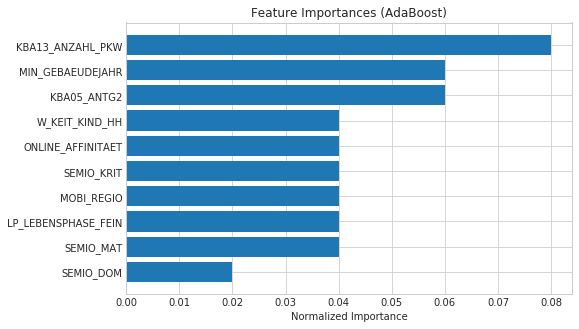

In [150]:
plot_feature_importances(model=best_adaboost, model_name="AdaBoost", feature_names=X.columns)


Summary:

According to our model, the most important features, listed in order of thier importance are shown in the plot above. These features include the affinity indicating in what way the person is critical minded, number of households known in this building, consumption movement in the last 12 months, number of cars in the PLZ8 and so on




### Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link here, you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

We will read in our file

In [151]:
df_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [152]:
df_test.shape

(42833, 366)

In [153]:
df_test_LNR = df_test["LNR"]
df_test_LNR.shape

(42833,)

In [154]:
rn=7628
drop1 = np.random.choice(df_test_LNR.index, rn,replace=False)
df_test_LNR= df_test_LNR.drop(drop1)

In [155]:
a = ['ALTERSKATEGORIE_GROB','ANREDE_KZ','CJT_GESAMTTYP','FINANZ_MINIMALIST','FINANZ_SPARER','FINANZ_VORSORGER','FINANZ_ANLEGER','FINANZ_UNAUFFAELLIGER','FINANZ_HAUSBAUER','FINANZTYP','GFK_URLAUBERTYP','GREEN_AVANTGARDE',
 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','LP_FAMILIE_FEIN','LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
 'SEMIO_FAM','SEMIO_REL','SEMIO_MAT','SEMIO_VERT','SEMIO_LUST','SEMIO_ERL','SEMIO_KULT','SEMIO_RAT','SEMIO_KRIT','SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT','SEMIO_TRADV','SHOPPER_TYP','SOHO_KZ',
 'VERS_TYP','ZABEOTYP','ANZ_PERSONEN','ANZ_TITEL','HH_EINKOMMEN_SCORE','KK_KUNDENTYP','W_KEIT_KIND_HH','WOHNDAUER_2008','ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','GEBAEUDETYP','KONSUMNAEHE','MIN_GEBAEUDEJAHR','OST_WEST_KZ','WOHNLAGE','CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015','KBA05_ANTG1',
 'KBA05_ANTG2','KBA05_ANTG3','KBA05_ANTG4','KBA05_GBZ','BALLRAUM','EWDICHTE','INNENSTADT','GEBAEUDETYP_RASTER','KKK','MOBI_REGIO','ONLINE_AFFINITAET','REGIOTYP','KBA13_ANZAHL_PKW','PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4','PLZ8_BAUMAX','PLZ8_HHZ','PLZ8_GBZ','ARBEIT','ORTSGR_KLS9','RELAT_AB']

In [156]:
df_test1=df_test[df_test.columns[df_test.columns.isin(a)]]

In [157]:
df_test1.shape

(42833, 80)

In [158]:
df_test1=clean_data(df_test1)

In [159]:
df_test1.shape

(35205, 79)

In [160]:
df_test1.drop(['KK_KUNDENTYP'], axis = 1)

ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  ARBEIT  \
0                      2.0           0.0           2.0        0.0     3.0   
1                     20.0           0.0           1.0        0.0     4.0   
2                      2.0           0.0           4.0        0.0     4.0   
3                      1.0           0.0           0.0        0.0     4.0   
4                      1.0           0.0           4.0        0.0     3.0   
5                     66.0           0.0           1.0        0.0     4.0   
6                      1.0           0.0           2.0        0.0     4.0   
7                      1.0           0.0           4.0        0.0     3.0   
8                      2.0           0.0           4.0        0.0     2.0   
9                      1.0           0.0           1.0        0.0     3.0   
10                     2.0           0.0           2.0        0.0     2.0   
11                     8.0           0.0           1.0        0.0     3.0   
12                     1.0           0.0           4.0        0.0     2.0   
14                     2.0           0.0           1.0        0.0     4.0   
15                     1.0           0.0           2.0        0.0     3.0   
16                     1.0           0.0           5.0        0.0     4.0   
17                    10.0           0.0           1.0        0.0     5.0   
18                     2.0           0.0           4.0        0.0     2.0   
19                    11.0           0.0           1.0        0.0     3.0   
20                     2.0           0.0           5.0        0.0     4.0   
21                     2.0           0.0           4.0        0.0     3.0   
22                     1.0           0.0           2.0        0.0     3.0   
23                     2.0           0.0           2.0        0.0     1.0   
24                    12.0           0.0           1.0        0.0     3.0   
25                     1.0           0.0           4.0        0.0     4.0   
26                     1.0           0.0           2.0        0.0     5.0   
27                     1.0           0.0           1.0        0.0     2.0   
28                     1.0           0.0           2.0        0.0     4.0   
30                     2.0           0.0           6.0        0.0     3.0   
31                     1.0           0.0           2.0        0.0     1.0   
33                     1.0           0.0           4.0        0.0     3.0   
34                     1.0           0.0           2.0        0.0     4.0   
35                     3.0           0.0           2.0        0.0     2.0   
37                     5.0           0.0           1.0        0.0     4.0   
38                     4.0           0.0           1.0        0.0     3.0   
39                     1.0           0.0           3.0        0.0     2.0   
40                     1.0           0.0           2.0        0.0     3.0   
41                     8.0           0.0           1.0        0.0     4.0   
42                     5.0           0.0           1.0        0.0     4.0   
43                     1.0           0.0           5.0        0.0     2.0   
44                     1.0           0.0           3.0        0.0     3.0   
46                     2.0           0.0           2.0        0.0     3.0   
47                     1.0           0.0           3.0        0.0     3.0   
48                     1.0           0.0           2.0        0.0     2.0   
49                     1.0           0.0           0.0        0.0     4.0   
50                     1.0           0.0           3.0        0.0     3.0   
51                     3.0           0.0           2.0        0.0     2.0   
53                     1.0           0.0           4.0        0.0     3.0   
54                     1.0           0.0           2.0        0.0     3.0   
55                    11.0           0.0           0.0        0.0     4.0   
56                     1.0           0.0           2.0        0.0     1.0   
57 

In [161]:
df_test1= df_test1.fillna(df_test1.mode().iloc[0])

In [162]:
best_adaboost.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.9, n_estimators=50, random_state=2)

In [163]:
preds_test_adaboost = best_adaboost.predict_proba(df_test1)[:,1]


In [164]:
kaggle_submi = pd.DataFrame(index=df_test_LNR, data=preds_test_adaboost)
kaggle_submi.rename(columns={0: "RESPONSE"}, inplace=True)


In [165]:
kaggle_submi.head()

RESPONSE
LNR           
1754  0.494576
1770  0.494992
1465  0.496007
1470  0.493234
1478  0.492911

In [166]:
#kaggle_submi.to_csv('KaggleSubmission.csv')

### Conclusion

###### Reflection:

One of the major factor that made this project a bit tedious is the time taken for the code cells to run. This is mostly due to the size of the dataset being worked upon for the project. Fitting our adboost model was also time consuming due to computational reasons.


###### Improvement:

This project can be improved on by using other models will higher scores. All the model investigated in the project had AUCROC_score less than 0.7. Hence, for further research, more efficient model with higher scores can be deployed